In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! git clone https://github.com/amirgholami/adahessian.git #original, if we want to modify something need to replace with a forked one

fatal: destination path 'adahessian' already exists and is not an empty directory.


In [3]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")
#import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [4]:
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [5]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.model_selection import KFold
#import torch_xla
#import torch_xla.core.xla_model as xm

from optimizer import set_parameter_requires_grad, initialize_model, train_and_test, test_model
from optim_adahessian import Adahessian

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
# classic dataset
train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=ToTensor())
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Use a small subset of the data
# only error: 'Subset' object has no attribute 'targets'
if False: # put False if don't want it
  rng = np.random.default_rng()

  indices = rng.choice(len(train_data), 1000, replace=False)
  train_data = torch.utils.data.Subset(train_data, indices)

  indices = rng.choice(len(test_data), 200, replace=False)
  test_data = torch.utils.data.Subset(test_data, indices)

In [8]:
print("train data of type:",type(train_data),"with length",len(train_data))
print("test data of type:",type(test_data),"with length",len(test_data))

train data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 50000
test data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 10000


In [9]:
print("samples of type",type(train_data[0]),"with length",len(train_data[0]))
print("   - First entry: Image of type",type(train_data[0][0]),"and size",train_data[0][0].size())
print("   - Second entry: Label of type",type(train_data[0][1]))
print("The first sample:\n",train_data[0])

samples of type <class 'tuple'> with length 2
   - First entry: Image of type <class 'torch.Tensor'> and size torch.Size([3, 32, 32])
   - Second entry: Label of type <class 'int'>
The first sample:
 (tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627

In [10]:
labels=np.unique(np.array(train_data.targets)) #don't seem to work for all datasets, like 'Subset' objects
print(labels)

[0 1 2 3 4 5 6 7 8 9]


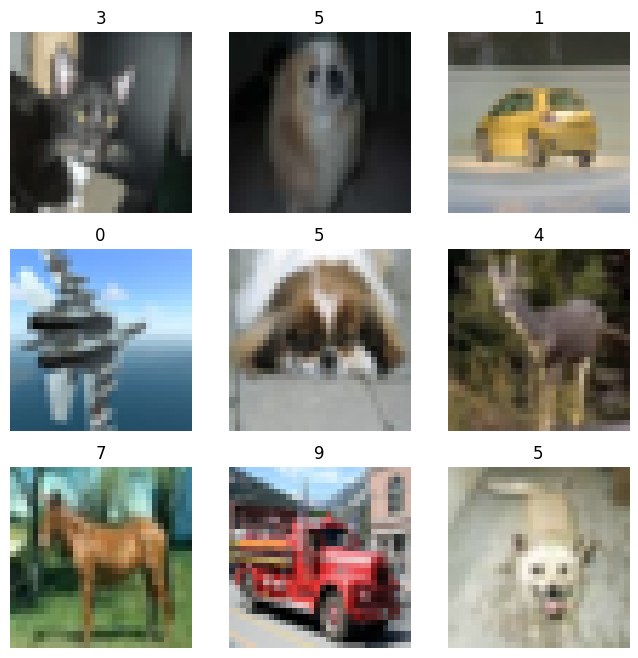

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

In [12]:
batch_size = 256
seed = 100
k_folds = 5
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True) #change batch size with our need
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
kfold = KFold(n_splits=k_folds, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#device = xm.xla_device()

Using cuda device


In [14]:
req_grad = True
use_pretrained=False
# Initialize the model for this run
model, input_size = initialize_model(use_pretrained=use_pretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
# Send the model to GPU

model = model.to(device)
#model.load_state_dict(torch.load('./drive/MyDrive/Opti-ML/model_weights/model_adahessian.pt', map_location=lambda storage, loc: storage.cuda(0)))
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if req_grad:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

[image_classification/optim_adahessian.py](https://github.com/amirgholami/adahessian/blob/master/image_classification/optim_adahessian.py) on github:


```
"""Implements Adahessian algorithm.
    It has been proposed in `ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning`.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 0.15)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-4)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hessian_power (float, optional): Hessian power (default: 1). You can also try 0.5. For some tasks we found this to result in better performance.
        single_gpu (Bool, optional): Do you use distributed training or not "torch.nn.parallel.DistributedDataParallel" (default: True)
    """
```
- hessian_power is the "$k$"
- the weight decay is something like 0.1,...,0.0001


In [16]:
lr=0.15 # default: 0.15
betas = (0.9, 0.999) # default: (0.9, 0.999)
weight_decay = 0.0005 # default: 0
hessian_power = 1 # default: 1
num_epoch = 160
momentum = 0.95

#optimizer_name = 'adahessian'
optimizer_name = 'adahessian'

if optimizer_name == 'adahessian':
  optimizer = Adahessian(params_to_update, lr=lr, betas=betas, weight_decay=weight_decay,hessian_power=hessian_power) #set the parameter
elif optimizer_name == 'SGD':
  optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "adam":
  optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

scheduler_name = "multilr"
scheduler = None
if scheduler_name == "multilr":
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80, 120], gamma=0.1)

path='./drive/MyDrive/Opti-ML/model_weights/model_0615_adah'
train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/train_loss_0615_1.txt'
train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/train_acc_0615_1.txt'
val_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/val_loss_0615_1.txt'
val_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/val_acc_0615_1.txt'

The following cell takes ~180 second/epoch for batchsize=16

In [ ]:
#check the warning, nothing more on the adahessian git
best_k, train_loss, val_loss, train_acc, val_acc=train_and_test(model,train_data,batch_size,kfold,criterion,optimizer_name,scheduler,num_epoch,path,use_pretrained,lr,betas,momentum,weight_decay,hessian_power,device)
with open(train_loss_path, 'w') as fp:
    for item in train_loss:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(train_acc_path, 'w') as fp:
    for item in train_acc:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(val_loss_path, 'w') as fp:
    for item in val_loss:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(val_acc_path, 'w') as fp:
    for item in val_acc:
        # write each item on a new line
        fp.write("%s\n" % item)

FOLD 0
--------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 0/159
----------


/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Loss: 1.2256
Validation Loss: 1.4546


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  1%|          | 1/160 [00:45<1:59:30, 45.10s/it]

Train accuracy: 0.4050
Validation accuracy: 0.3979
Epoch 1/159
----------
Train Loss: 0.8933
Validation Loss: 1.1982


  1%|▏         | 2/160 [01:28<1:55:57, 44.04s/it]

Train accuracy: 0.5106
Validation accuracy: 0.4835
Epoch 2/159
----------
Train Loss: 0.7448
Validation Loss: 0.9026


  2%|▏         | 3/160 [02:11<1:54:38, 43.81s/it]

Train accuracy: 0.6462
Validation accuracy: 0.6016
Epoch 3/159
----------
Train Loss: 0.6362
Validation Loss: 0.8127


  2%|▎         | 4/160 [02:55<1:53:45, 43.75s/it]

Train accuracy: 0.7200
Validation accuracy: 0.6613
Epoch 4/159
----------
Train Loss: 0.5496
Validation Loss: 0.8847


  3%|▎         | 5/160 [03:39<1:53:15, 43.84s/it]

Train accuracy: 0.6990
Validation accuracy: 0.6320
Epoch 5/159
----------
Train Loss: 0.4863
Validation Loss: 0.9046


  4%|▍         | 6/160 [04:23<1:52:30, 43.83s/it]

Train accuracy: 0.7299
Validation accuracy: 0.6456
Epoch 6/159
----------
Train Loss: 0.4191
Validation Loss: 0.7151


  4%|▍         | 7/160 [05:06<1:51:33, 43.75s/it]

Train accuracy: 0.8292
Validation accuracy: 0.7072
Epoch 7/159
----------
Train Loss: 0.3660
Validation Loss: 0.7763


  5%|▌         | 8/160 [05:50<1:51:00, 43.82s/it]

Train accuracy: 0.8187
Validation accuracy: 0.6920
Epoch 8/159
----------
Train Loss: 0.3162
Validation Loss: 0.8816


  6%|▌         | 9/160 [06:34<1:50:19, 43.84s/it]

Train accuracy: 0.8020
Validation accuracy: 0.6699
Epoch 9/159
----------
Train Loss: 0.2678
Validation Loss: 0.8043


  6%|▋         | 10/160 [07:18<1:49:39, 43.86s/it]

Train accuracy: 0.8672
Validation accuracy: 0.7056
Epoch 10/159
----------
Train Loss: 0.2324
Validation Loss: 0.8335


  7%|▋         | 11/160 [08:02<1:49:07, 43.94s/it]

Train accuracy: 0.8845
Validation accuracy: 0.7092
Epoch 11/159
----------
Train Loss: 0.1927
Validation Loss: 0.9193


  8%|▊         | 12/160 [08:47<1:48:41, 44.06s/it]

Train accuracy: 0.8870
Validation accuracy: 0.6971
Epoch 12/159
----------
Train Loss: 0.1745
Validation Loss: 0.8815


  8%|▊         | 13/160 [09:31<1:47:57, 44.06s/it]

Train accuracy: 0.9042
Validation accuracy: 0.7068
Epoch 13/159
----------
Train Loss: 0.1547
Validation Loss: 1.1037


  9%|▉         | 14/160 [10:15<1:47:18, 44.10s/it]

Train accuracy: 0.8674
Validation accuracy: 0.6876
Epoch 14/159
----------
Train Loss: 0.1392
Validation Loss: 0.9534


  9%|▉         | 15/160 [10:59<1:46:36, 44.11s/it]

Train accuracy: 0.9008
Validation accuracy: 0.7022
Epoch 15/159
----------
Train Loss: 0.1230
Validation Loss: 1.2866


 10%|█         | 16/160 [11:43<1:45:58, 44.15s/it]

Train accuracy: 0.8231
Validation accuracy: 0.6616
Epoch 16/159
----------
Train Loss: 0.1071
Validation Loss: 1.0169


 11%|█         | 17/160 [12:28<1:45:22, 44.21s/it]

Train accuracy: 0.9287
Validation accuracy: 0.7096
Epoch 17/159
----------
Train Loss: 0.0993
Validation Loss: 1.1064


 11%|█▏        | 18/160 [13:12<1:44:46, 44.27s/it]

Train accuracy: 0.9107
Validation accuracy: 0.6881
Epoch 18/159
----------
Train Loss: 0.0926
Validation Loss: 1.3411


 12%|█▏        | 19/160 [13:56<1:43:58, 44.25s/it]

Train accuracy: 0.8336
Validation accuracy: 0.6436
Epoch 19/159
----------
Train Loss: 0.0877
Validation Loss: 1.0365


 12%|█▎        | 20/160 [14:40<1:43:10, 44.21s/it]

Train accuracy: 0.9301
Validation accuracy: 0.7125
Epoch 20/159
----------
Train Loss: 0.0810
Validation Loss: 1.0516


 13%|█▎        | 21/160 [15:25<1:42:28, 44.23s/it]

Train accuracy: 0.9333
Validation accuracy: 0.7029
Epoch 21/159
----------
Train Loss: 0.0878
Validation Loss: 1.2420


 14%|█▍        | 22/160 [16:09<1:41:44, 44.24s/it]

Train accuracy: 0.8854
Validation accuracy: 0.6783
Epoch 22/159
----------
Train Loss: 0.0737
Validation Loss: 1.1365


 14%|█▍        | 23/160 [16:53<1:40:50, 44.16s/it]

Train accuracy: 0.9349
Validation accuracy: 0.7001
Epoch 23/159
----------
Train Loss: 0.0707
Validation Loss: 1.1698


 15%|█▌        | 24/160 [17:37<1:40:12, 44.21s/it]

Train accuracy: 0.9225
Validation accuracy: 0.7041
Epoch 24/159
----------
Train Loss: 0.0823
Validation Loss: 1.5604


 16%|█▌        | 25/160 [18:21<1:39:24, 44.18s/it]

Train accuracy: 0.7808
Validation accuracy: 0.5958
Epoch 25/159
----------
Train Loss: 0.0682
Validation Loss: 1.1179


 16%|█▋        | 26/160 [19:06<1:38:41, 44.19s/it]

Train accuracy: 0.9449
Validation accuracy: 0.7110
Epoch 26/159
----------
Train Loss: 0.0725
Validation Loss: 1.1092


 17%|█▋        | 27/160 [19:50<1:37:54, 44.17s/it]

Train accuracy: 0.9568
Validation accuracy: 0.7256
Epoch 27/159
----------
Train Loss: 0.0697
Validation Loss: 1.1328


 18%|█▊        | 28/160 [20:34<1:37:19, 44.24s/it]

Train accuracy: 0.9439
Validation accuracy: 0.7028
Epoch 28/159
----------
Train Loss: 0.0677
Validation Loss: 1.1621


 18%|█▊        | 29/160 [21:18<1:36:25, 44.17s/it]

Train accuracy: 0.9247
Validation accuracy: 0.7025
Epoch 29/159
----------
Train Loss: 0.0732
Validation Loss: 1.0787


 19%|█▉        | 30/160 [22:02<1:35:44, 44.18s/it]

Train accuracy: 0.9458
Validation accuracy: 0.7119
Epoch 30/159
----------
Train Loss: 0.0669
Validation Loss: 1.1866


 19%|█▉        | 31/160 [22:46<1:34:49, 44.10s/it]

Train accuracy: 0.9403
Validation accuracy: 0.7079
Epoch 31/159
----------
Train Loss: 0.0649
Validation Loss: 1.0591


 20%|██        | 32/160 [23:31<1:34:18, 44.21s/it]

Train accuracy: 0.9637
Validation accuracy: 0.7296
Epoch 32/159
----------
Train Loss: 0.0620
Validation Loss: 1.1505


 21%|██        | 33/160 [24:15<1:33:40, 44.25s/it]

Train accuracy: 0.9371
Validation accuracy: 0.7042
Epoch 33/159
----------
Train Loss: 0.0666
Validation Loss: 1.0761


 21%|██▏       | 34/160 [24:59<1:32:34, 44.09s/it]

Train accuracy: 0.9570
Validation accuracy: 0.7199
Epoch 34/159
----------
Train Loss: 0.0683
Validation Loss: 1.0446


 22%|██▏       | 35/160 [25:43<1:32:02, 44.18s/it]

Train accuracy: 0.9563
Validation accuracy: 0.7214
Epoch 35/159
----------
Train Loss: 0.0616
Validation Loss: 1.1235


 22%|██▎       | 36/160 [26:27<1:31:19, 44.19s/it]

Train accuracy: 0.9448
Validation accuracy: 0.6969
Epoch 36/159
----------
Train Loss: 0.0601
Validation Loss: 1.1804


 23%|██▎       | 37/160 [27:12<1:30:39, 44.23s/it]

Train accuracy: 0.9254
Validation accuracy: 0.7076
Epoch 37/159
----------
Train Loss: 0.0567
Validation Loss: 1.1651


 24%|██▍       | 38/160 [27:56<1:29:44, 44.14s/it]

Train accuracy: 0.9417
Validation accuracy: 0.7129
Epoch 38/159
----------
Train Loss: 0.0618
Validation Loss: 1.0267


 24%|██▍       | 39/160 [28:40<1:29:13, 44.25s/it]

Train accuracy: 0.9576
Validation accuracy: 0.7203
Epoch 39/159
----------
Train Loss: 0.0698
Validation Loss: 1.4332


 25%|██▌       | 40/160 [29:25<1:28:51, 44.43s/it]

Train accuracy: 0.8656
Validation accuracy: 0.6515
Epoch 40/159
----------
Train Loss: 0.0594
Validation Loss: 1.1694


 26%|██▌       | 41/160 [30:09<1:27:58, 44.36s/it]

Train accuracy: 0.9496
Validation accuracy: 0.7085
Epoch 41/159
----------
Train Loss: 0.0572
Validation Loss: 1.1706


 26%|██▋       | 42/160 [30:54<1:27:23, 44.43s/it]

Train accuracy: 0.9539
Validation accuracy: 0.7222
Epoch 42/159
----------
Train Loss: 0.0610
Validation Loss: 1.0946


 27%|██▋       | 43/160 [31:38<1:26:32, 44.38s/it]

Train accuracy: 0.9637
Validation accuracy: 0.7249
Epoch 43/159
----------
Train Loss: 0.0602
Validation Loss: 1.1049


 28%|██▊       | 44/160 [32:23<1:25:56, 44.45s/it]

Train accuracy: 0.9561
Validation accuracy: 0.7197
Epoch 44/159
----------
Train Loss: 0.0614
Validation Loss: 1.2027


 28%|██▊       | 45/160 [33:07<1:25:14, 44.47s/it]

Train accuracy: 0.9247
Validation accuracy: 0.6891
Epoch 45/159
----------
Train Loss: 0.0566
Validation Loss: 1.1936


 29%|██▉       | 46/160 [33:52<1:24:29, 44.47s/it]

Train accuracy: 0.9529
Validation accuracy: 0.7107
Epoch 46/159
----------
Train Loss: 0.0659
Validation Loss: 1.1138


 29%|██▉       | 47/160 [34:36<1:23:48, 44.50s/it]

Train accuracy: 0.9510
Validation accuracy: 0.7185
Epoch 47/159
----------
Train Loss: 0.0620
Validation Loss: 1.1055


 30%|███       | 48/160 [35:21<1:23:06, 44.52s/it]

Train accuracy: 0.9510
Validation accuracy: 0.7140
Epoch 48/159
----------
Train Loss: 0.0615
Validation Loss: 1.0916


 31%|███       | 49/160 [36:05<1:22:23, 44.53s/it]

Train accuracy: 0.9467
Validation accuracy: 0.7160
Epoch 49/159
----------
Train Loss: 0.0596
Validation Loss: 1.0908


 31%|███▏      | 50/160 [36:50<1:21:32, 44.48s/it]

Train accuracy: 0.9502
Validation accuracy: 0.7140
Epoch 50/159
----------
Train Loss: 0.0571
Validation Loss: 1.0434


 32%|███▏      | 51/160 [37:34<1:20:50, 44.50s/it]

Train accuracy: 0.9736
Validation accuracy: 0.7289
Epoch 51/159
----------
Train Loss: 0.0623
Validation Loss: 1.1596


 32%|███▎      | 52/160 [38:19<1:20:08, 44.53s/it]

Train accuracy: 0.9478
Validation accuracy: 0.7113
Epoch 52/159
----------
Train Loss: 0.0585
Validation Loss: 1.1005


 33%|███▎      | 53/160 [39:03<1:19:16, 44.46s/it]

Train accuracy: 0.9579
Validation accuracy: 0.7259
Epoch 53/159
----------
Train Loss: 0.0605
Validation Loss: 1.3187


 34%|███▍      | 54/160 [39:48<1:18:35, 44.48s/it]

Train accuracy: 0.9255
Validation accuracy: 0.6951
Epoch 54/159
----------
Train Loss: 0.0506
Validation Loss: 1.2338


 34%|███▍      | 55/160 [40:32<1:17:50, 44.48s/it]

Train accuracy: 0.9170
Validation accuracy: 0.7039
Epoch 55/159
----------
Train Loss: 0.0636
Validation Loss: 1.1662


 35%|███▌      | 56/160 [41:17<1:17:11, 44.53s/it]

Train accuracy: 0.9453
Validation accuracy: 0.7065
Epoch 56/159
----------
Train Loss: 0.0551
Validation Loss: 1.1170


 36%|███▌      | 57/160 [42:01<1:16:28, 44.54s/it]

Train accuracy: 0.9696
Validation accuracy: 0.7292
Epoch 57/159
----------
Train Loss: 0.0615
Validation Loss: 1.0877


 36%|███▋      | 58/160 [42:46<1:15:40, 44.52s/it]

Train accuracy: 0.9597
Validation accuracy: 0.7184
Epoch 58/159
----------
Train Loss: 0.0577
Validation Loss: 1.1797


 37%|███▋      | 59/160 [43:30<1:14:56, 44.52s/it]

Train accuracy: 0.9380
Validation accuracy: 0.7058
Epoch 59/159
----------
Train Loss: 0.0532
Validation Loss: 1.1378


 38%|███▊      | 60/160 [44:15<1:14:07, 44.48s/it]

Train accuracy: 0.9644
Validation accuracy: 0.7207
Epoch 60/159
----------
Train Loss: 0.0653
Validation Loss: 1.1016


 38%|███▊      | 61/160 [44:59<1:13:25, 44.50s/it]

Train accuracy: 0.9395
Validation accuracy: 0.7043
Epoch 61/159
----------
Train Loss: 0.0515
Validation Loss: 1.1280


 39%|███▉      | 62/160 [45:44<1:12:38, 44.48s/it]

Train accuracy: 0.9657
Validation accuracy: 0.7206
Epoch 62/159
----------
Train Loss: 0.0520
Validation Loss: 1.0708


 39%|███▉      | 63/160 [46:28<1:11:52, 44.46s/it]

Train accuracy: 0.9772
Validation accuracy: 0.7318
Epoch 63/159
----------
Train Loss: 0.0546
Validation Loss: 1.1266


 40%|████      | 64/160 [47:13<1:11:06, 44.45s/it]

Train accuracy: 0.9555
Validation accuracy: 0.7188
Epoch 64/159
----------
Train Loss: 0.0519
Validation Loss: 1.0955


 41%|████      | 65/160 [47:57<1:10:27, 44.50s/it]

Train accuracy: 0.9653
Validation accuracy: 0.7233
Epoch 65/159
----------
Train Loss: 0.0495
Validation Loss: 1.1275


 41%|████▏     | 66/160 [48:42<1:09:44, 44.52s/it]

Train accuracy: 0.9599
Validation accuracy: 0.7182
Epoch 66/159
----------
Train Loss: 0.0625
Validation Loss: 1.1529


 42%|████▏     | 67/160 [49:26<1:08:52, 44.43s/it]

Train accuracy: 0.9183
Validation accuracy: 0.6964
Epoch 67/159
----------
Train Loss: 0.0586
Validation Loss: 1.0470


 42%|████▎     | 68/160 [50:11<1:08:12, 44.49s/it]

Train accuracy: 0.9672
Validation accuracy: 0.7199
Epoch 68/159
----------
Train Loss: 0.0525
Validation Loss: 1.1139


 43%|████▎     | 69/160 [50:55<1:07:31, 44.53s/it]

Train accuracy: 0.9558
Validation accuracy: 0.7240
Epoch 69/159
----------
Train Loss: 0.0490
Validation Loss: 1.1602


 44%|████▍     | 70/160 [51:39<1:06:39, 44.44s/it]

Train accuracy: 0.9519
Validation accuracy: 0.7119
Epoch 70/159
----------
Train Loss: 0.0547
Validation Loss: 1.0475


 44%|████▍     | 71/160 [52:24<1:05:55, 44.44s/it]

Train accuracy: 0.9756
Validation accuracy: 0.7276
Epoch 71/159
----------
Train Loss: 0.0489
Validation Loss: 1.3148


 45%|████▌     | 72/160 [53:08<1:05:13, 44.48s/it]

Train accuracy: 0.9231
Validation accuracy: 0.6977
Epoch 72/159
----------
Train Loss: 0.0554
Validation Loss: 1.0462


 46%|████▌     | 73/160 [53:53<1:04:31, 44.50s/it]

Train accuracy: 0.9710
Validation accuracy: 0.7337
Epoch 73/159
----------
Train Loss: 0.0472
Validation Loss: 1.3298


 46%|████▋     | 74/160 [54:38<1:03:51, 44.55s/it]

Train accuracy: 0.9182
Validation accuracy: 0.6839
Epoch 74/159
----------
Train Loss: 0.0518
Validation Loss: 1.1652


 47%|████▋     | 75/160 [55:22<1:03:04, 44.52s/it]

Train accuracy: 0.9571
Validation accuracy: 0.7142
Epoch 75/159
----------
Train Loss: 0.0443
Validation Loss: 1.1396


 48%|████▊     | 76/160 [56:07<1:02:19, 44.51s/it]

Train accuracy: 0.9739
Validation accuracy: 0.7260
Epoch 76/159
----------
Train Loss: 0.0509
Validation Loss: 1.1073


 48%|████▊     | 77/160 [56:51<1:01:31, 44.48s/it]

Train accuracy: 0.9639
Validation accuracy: 0.7132
Epoch 77/159
----------
Train Loss: 0.0573
Validation Loss: 1.3456


 49%|████▉     | 78/160 [57:36<1:00:52, 44.54s/it]

Train accuracy: 0.9330
Validation accuracy: 0.7034
Epoch 78/159
----------
Train Loss: 0.0519
Validation Loss: 1.0292


 49%|████▉     | 79/160 [58:20<1:00:02, 44.48s/it]

Train accuracy: 0.9816
Validation accuracy: 0.7367
Epoch 79/159
----------
Train Loss: 0.0491
Validation Loss: 1.0556


 50%|█████     | 80/160 [59:04<59:16, 44.46s/it]  

Train accuracy: 0.9761
Validation accuracy: 0.7315
Epoch 80/159
----------
Train Loss: 0.0470
Validation Loss: 1.4962


 51%|█████     | 81/160 [59:49<58:39, 44.55s/it]

Train accuracy: 0.8715
Validation accuracy: 0.6614
Epoch 81/159
----------
Train Loss: 0.0517
Validation Loss: 1.1369


 51%|█████▏    | 82/160 [1:00:34<57:55, 44.56s/it]

Train accuracy: 0.9687
Validation accuracy: 0.7274
Epoch 82/159
----------
Train Loss: 0.0525
Validation Loss: 1.1876


 52%|█████▏    | 83/160 [1:01:18<57:14, 44.60s/it]

Train accuracy: 0.9442
Validation accuracy: 0.7161
Epoch 83/159
----------
Train Loss: 0.0528
Validation Loss: 1.1293


 52%|█████▎    | 84/160 [1:02:03<56:27, 44.57s/it]

Train accuracy: 0.9544
Validation accuracy: 0.7138
Epoch 84/159
----------
Train Loss: 0.0435
Validation Loss: 1.5147


 53%|█████▎    | 85/160 [1:02:48<55:42, 44.57s/it]

Train accuracy: 0.9040
Validation accuracy: 0.6805
Epoch 85/159
----------
Train Loss: 0.0531
Validation Loss: 1.0791


 54%|█████▍    | 86/160 [1:03:32<54:56, 44.55s/it]

Train accuracy: 0.9719
Validation accuracy: 0.7209
Epoch 86/159
----------
Train Loss: 0.0404
Validation Loss: 1.3773


 54%|█████▍    | 87/160 [1:04:17<54:13, 44.56s/it]

Train accuracy: 0.9143
Validation accuracy: 0.6856
Epoch 87/159
----------
Train Loss: 0.0451
Validation Loss: 1.1611


 55%|█████▌    | 88/160 [1:05:01<53:31, 44.61s/it]

Train accuracy: 0.9532
Validation accuracy: 0.7204
Epoch 88/159
----------
Train Loss: 0.0495
Validation Loss: 1.2415


 56%|█████▌    | 89/160 [1:05:46<52:42, 44.54s/it]

Train accuracy: 0.9529
Validation accuracy: 0.7051
Epoch 89/159
----------
Train Loss: 0.0515
Validation Loss: 1.1511


 56%|█████▋    | 90/160 [1:06:30<51:57, 44.54s/it]

Train accuracy: 0.9637
Validation accuracy: 0.7211
Epoch 90/159
----------
Train Loss: 0.0463
Validation Loss: 1.1261


 57%|█████▋    | 91/160 [1:07:15<51:08, 44.48s/it]

Train accuracy: 0.9532
Validation accuracy: 0.7229
Epoch 91/159
----------
Train Loss: 0.0447
Validation Loss: 1.1238


 57%|█████▊    | 92/160 [1:07:59<50:29, 44.55s/it]

Train accuracy: 0.9738
Validation accuracy: 0.7342
Epoch 92/159
----------
Train Loss: 0.0489
Validation Loss: 1.1468


 58%|█████▊    | 93/160 [1:08:44<49:39, 44.47s/it]

Train accuracy: 0.9607
Validation accuracy: 0.7187
Epoch 93/159
----------
Train Loss: 0.0472
Validation Loss: 1.0340


 59%|█████▉    | 94/160 [1:09:28<48:50, 44.40s/it]

Train accuracy: 0.9833
Validation accuracy: 0.7394
Epoch 94/159
----------
Train Loss: 0.0405
Validation Loss: 1.5282


 59%|█████▉    | 95/160 [1:10:12<48:02, 44.35s/it]

Train accuracy: 0.8850
Validation accuracy: 0.6709
Epoch 95/159
----------
Train Loss: 0.0418
Validation Loss: 1.3741


 60%|██████    | 96/160 [1:10:56<47:14, 44.29s/it]

Train accuracy: 0.9187
Validation accuracy: 0.6853
Epoch 96/159
----------
Train Loss: 0.0387
Validation Loss: 1.2852


 61%|██████    | 97/160 [1:11:40<46:24, 44.20s/it]

Train accuracy: 0.9415
Validation accuracy: 0.7068
Epoch 97/159
----------
Train Loss: 0.0482
Validation Loss: 1.1416


 61%|██████▏   | 98/160 [1:12:25<45:44, 44.27s/it]

Train accuracy: 0.9727
Validation accuracy: 0.7318
Epoch 98/159
----------
Train Loss: 0.0386
Validation Loss: 1.4638


 62%|██████▏   | 99/160 [1:13:10<45:12, 44.46s/it]

Train accuracy: 0.8951
Validation accuracy: 0.6797
Epoch 99/159
----------
Train Loss: 0.0451
Validation Loss: 1.0625


 62%|██████▎   | 100/160 [1:13:54<44:31, 44.52s/it]

Train accuracy: 0.9831
Validation accuracy: 0.7407
Epoch 100/159
----------
Train Loss: 0.0470
Validation Loss: 1.0416


 63%|██████▎   | 101/160 [1:14:39<43:45, 44.51s/it]

Train accuracy: 0.9861
Validation accuracy: 0.7414
Epoch 101/159
----------
Train Loss: 0.0413
Validation Loss: 1.1270


 64%|██████▍   | 102/160 [1:15:23<42:57, 44.43s/it]

Train accuracy: 0.9659
Validation accuracy: 0.7232
Epoch 102/159
----------
Train Loss: 0.0457
Validation Loss: 1.0425


 64%|██████▍   | 103/160 [1:16:07<42:13, 44.46s/it]

Train accuracy: 0.9807
Validation accuracy: 0.7397
Epoch 103/159
----------
Train Loss: 0.0413
Validation Loss: 1.1492


 65%|██████▌   | 104/160 [1:16:52<41:30, 44.48s/it]

Train accuracy: 0.9827
Validation accuracy: 0.7418
Epoch 104/159
----------
Train Loss: 0.0401
Validation Loss: 1.2512


 66%|██████▌   | 105/160 [1:17:36<40:44, 44.45s/it]

Train accuracy: 0.9636
Validation accuracy: 0.7165
Epoch 105/159
----------
Train Loss: 0.0419
Validation Loss: 1.1367


 66%|██████▋   | 106/160 [1:18:21<40:00, 44.45s/it]

Train accuracy: 0.9702
Validation accuracy: 0.7316
Epoch 106/159
----------
Train Loss: 0.0436
Validation Loss: 1.2336


 67%|██████▋   | 107/160 [1:19:05<39:10, 44.35s/it]

Train accuracy: 0.9553
Validation accuracy: 0.7131
Epoch 107/159
----------
Train Loss: 0.0498
Validation Loss: 1.2862


 68%|██████▊   | 108/160 [1:19:49<38:24, 44.32s/it]

Train accuracy: 0.9736
Validation accuracy: 0.7394
Epoch 108/159
----------
Train Loss: 1.1770
Validation Loss: 1.1578


 68%|██████▊   | 109/160 [1:20:33<37:35, 44.23s/it]

Train accuracy: 0.5016
Validation accuracy: 0.4830
Epoch 109/159
----------
Train Loss: 0.8815
Validation Loss: 0.8848


 69%|██████▉   | 110/160 [1:21:17<36:50, 44.20s/it]

Train accuracy: 0.6733
Validation accuracy: 0.6162
Epoch 110/159
----------
Train Loss: 0.5972
Validation Loss: 0.9271


 69%|██████▉   | 111/160 [1:22:02<36:06, 44.21s/it]

Train accuracy: 0.7334
Validation accuracy: 0.6271
Epoch 111/159
----------
Train Loss: 0.3966
Validation Loss: 0.7206


 70%|███████   | 112/160 [1:22:46<35:22, 44.22s/it]

Train accuracy: 0.8947
Validation accuracy: 0.7211
Epoch 112/159
----------
Train Loss: 0.2434
Validation Loss: 0.8909


 71%|███████   | 113/160 [1:23:30<34:37, 44.20s/it]

Train accuracy: 0.8692
Validation accuracy: 0.6911
Epoch 113/159
----------
Train Loss: 0.1684
Validation Loss: 1.1286


 71%|███████▏  | 114/160 [1:24:14<33:53, 44.20s/it]

Train accuracy: 0.8515
Validation accuracy: 0.6703
Epoch 114/159
----------
Train Loss: 0.1178
Validation Loss: 1.0560


 72%|███████▏  | 115/160 [1:24:59<33:11, 44.26s/it]

Train accuracy: 0.9183
Validation accuracy: 0.6913
Epoch 115/159
----------
Train Loss: 0.1013
Validation Loss: 0.9849


 72%|███████▎  | 116/160 [1:25:44<32:37, 44.49s/it]

Train accuracy: 0.9611
Validation accuracy: 0.7242
Epoch 116/159
----------
Train Loss: 0.0794
Validation Loss: 1.1112


 73%|███████▎  | 117/160 [1:26:28<31:50, 44.43s/it]

Train accuracy: 0.9374
Validation accuracy: 0.7125
Epoch 117/159
----------
Train Loss: 0.0694
Validation Loss: 1.1742


 74%|███████▍  | 118/160 [1:27:12<31:04, 44.39s/it]

Train accuracy: 0.9431
Validation accuracy: 0.6974
Epoch 118/159
----------
Train Loss: 0.0626
Validation Loss: 1.0104


 74%|███████▍  | 119/160 [1:27:56<30:18, 44.35s/it]

Train accuracy: 0.9794
Validation accuracy: 0.7361
Epoch 119/159
----------
Train Loss: 0.0509
Validation Loss: 1.0658


 75%|███████▌  | 120/160 [1:28:41<29:33, 44.35s/it]

Train accuracy: 0.9757
Validation accuracy: 0.7324
Epoch 120/159
----------
Train Loss: 0.0612
Validation Loss: 1.1107


 76%|███████▌  | 121/160 [1:29:25<28:49, 44.34s/it]

Train accuracy: 0.9648
Validation accuracy: 0.7265
Epoch 121/159
----------
Train Loss: 0.0499
Validation Loss: 1.2015


 76%|███████▋  | 122/160 [1:30:09<28:05, 44.35s/it]

Train accuracy: 0.9495
Validation accuracy: 0.7182
Epoch 122/159
----------
Train Loss: 0.0508
Validation Loss: 1.0233


 77%|███████▋  | 123/160 [1:30:54<27:24, 44.44s/it]

Train accuracy: 0.9852
Validation accuracy: 0.7407
Epoch 123/159
----------
Train Loss: 0.0459
Validation Loss: 1.3121


 78%|███████▊  | 124/160 [1:31:39<26:42, 44.51s/it]

Train accuracy: 0.9231
Validation accuracy: 0.6959
Epoch 124/159
----------
Train Loss: 0.0428
Validation Loss: 1.1285


 78%|███████▊  | 125/160 [1:32:24<26:01, 44.61s/it]

Train accuracy: 0.9795
Validation accuracy: 0.7289
Epoch 125/159
----------
Train Loss: 0.0425
Validation Loss: 1.1687


 79%|███████▉  | 126/160 [1:33:08<25:16, 44.60s/it]

Train accuracy: 0.9784
Validation accuracy: 0.7207
Epoch 126/159
----------
Train Loss: 0.0444
Validation Loss: 1.3686


 79%|███████▉  | 127/160 [1:33:53<24:32, 44.61s/it]

Train accuracy: 0.9130
Validation accuracy: 0.6877
Epoch 127/159
----------
Train Loss: 0.0446
Validation Loss: 1.2147


 80%|████████  | 128/160 [1:34:37<23:44, 44.52s/it]

Train accuracy: 0.9672
Validation accuracy: 0.7166
Epoch 128/159
----------
Train Loss: 0.0387
Validation Loss: 1.1492


 81%|████████  | 129/160 [1:35:21<22:57, 44.42s/it]

Train accuracy: 0.9742
Validation accuracy: 0.7243
Epoch 129/159
----------
Train Loss: 0.0386
Validation Loss: 1.4341


 81%|████████▏ | 130/160 [1:36:05<22:08, 44.30s/it]

Train accuracy: 0.9113
Validation accuracy: 0.6833
Epoch 130/159
----------
Train Loss: 0.0442
Validation Loss: 1.1576


 82%|████████▏ | 131/160 [1:36:49<21:20, 44.15s/it]

Train accuracy: 0.9617
Validation accuracy: 0.7126
Epoch 131/159
----------
Train Loss: 0.0495
Validation Loss: 1.1691


 82%|████████▎ | 132/160 [1:37:33<20:33, 44.05s/it]

Train accuracy: 0.9694
Validation accuracy: 0.7126
Epoch 132/159
----------
Train Loss: 0.0383
Validation Loss: 1.2907


 83%|████████▎ | 133/160 [1:38:16<19:44, 43.86s/it]

Train accuracy: 0.9665
Validation accuracy: 0.7087
Epoch 133/159
----------
Train Loss: 0.0382
Validation Loss: 1.1682


 84%|████████▍ | 134/160 [1:39:00<18:57, 43.76s/it]

Train accuracy: 0.9681
Validation accuracy: 0.7267
Epoch 134/159
----------
Train Loss: 0.0425
Validation Loss: 1.1663


 84%|████████▍ | 135/160 [1:39:44<18:12, 43.71s/it]

Train accuracy: 0.9741
Validation accuracy: 0.7297
Epoch 135/159
----------
Train Loss: 0.0402
Validation Loss: 1.1643


 85%|████████▌ | 136/160 [1:40:27<17:28, 43.68s/it]

Train accuracy: 0.9636
Validation accuracy: 0.7277
Epoch 136/159
----------
Train Loss: 0.0425
Validation Loss: 1.2589


 86%|████████▌ | 137/160 [1:41:11<16:42, 43.60s/it]

Train accuracy: 0.9536
Validation accuracy: 0.7032
Epoch 137/159
----------
Train Loss: 0.0363
Validation Loss: 1.2465


 86%|████████▋ | 138/160 [1:41:54<15:58, 43.56s/it]

Train accuracy: 0.9639
Validation accuracy: 0.7086
Epoch 138/159
----------
Train Loss: 0.0419
Validation Loss: 1.1356


 87%|████████▋ | 139/160 [1:42:37<15:13, 43.49s/it]

Train accuracy: 0.9842
Validation accuracy: 0.7302
Epoch 139/159
----------
Train Loss: 0.0247
Validation Loss: 1.2478


 88%|████████▊ | 140/160 [1:43:21<14:29, 43.49s/it]

Train accuracy: 0.9820
Validation accuracy: 0.7250
Epoch 140/159
----------
Train Loss: 0.0451
Validation Loss: 1.1740


 88%|████████▊ | 141/160 [1:44:05<13:52, 43.82s/it]

Train accuracy: 0.9732
Validation accuracy: 0.7225
Epoch 141/159
----------
Train Loss: 0.0371
Validation Loss: 1.2037


 89%|████████▉ | 142/160 [1:44:50<13:10, 43.90s/it]

Train accuracy: 0.9788
Validation accuracy: 0.7283
Epoch 142/159
----------
Train Loss: 0.0402
Validation Loss: 1.1425


 89%|████████▉ | 143/160 [1:45:34<12:28, 44.01s/it]

Train accuracy: 0.9833
Validation accuracy: 0.7306
Epoch 143/159
----------
Train Loss: 0.0343
Validation Loss: 1.1708


 90%|█████████ | 144/160 [1:46:18<11:43, 43.96s/it]

Train accuracy: 0.9765
Validation accuracy: 0.7243
Epoch 144/159
----------
Train Loss: 0.0372
Validation Loss: 1.2323


 91%|█████████ | 145/160 [1:47:02<10:59, 43.97s/it]

Train accuracy: 0.9657
Validation accuracy: 0.7133
Epoch 145/159
----------
Train Loss: 0.0356
Validation Loss: 1.1569


 91%|█████████▏| 146/160 [1:47:46<10:15, 43.96s/it]

Train accuracy: 0.9777
Validation accuracy: 0.7226
Epoch 146/159
----------
Train Loss: 0.0414
Validation Loss: 1.1222


 92%|█████████▏| 147/160 [1:48:30<09:32, 44.04s/it]

Train accuracy: 0.9889
Validation accuracy: 0.7463
Epoch 147/159
----------
Train Loss: 0.0340
Validation Loss: 1.2842


 92%|█████████▎| 148/160 [1:49:14<08:49, 44.15s/it]

Train accuracy: 0.9452
Validation accuracy: 0.7049
Epoch 148/159
----------
Train Loss: 0.0346
Validation Loss: 1.1760


 93%|█████████▎| 149/160 [1:49:58<08:05, 44.12s/it]

Train accuracy: 0.9750
Validation accuracy: 0.7353
Epoch 149/159
----------
Train Loss: 0.0349
Validation Loss: 1.1527


 94%|█████████▍| 150/160 [1:50:42<07:21, 44.15s/it]

Train accuracy: 0.9727
Validation accuracy: 0.7182
Epoch 150/159
----------
Train Loss: 0.0335
Validation Loss: 1.1885


 94%|█████████▍| 151/160 [1:51:27<06:37, 44.15s/it]

Train accuracy: 0.9737
Validation accuracy: 0.7239
Epoch 151/159
----------
Train Loss: 0.0392
Validation Loss: 1.2111


 95%|█████████▌| 152/160 [1:52:11<05:53, 44.21s/it]

Train accuracy: 0.9690
Validation accuracy: 0.7140
Epoch 152/159
----------
Train Loss: 0.0420
Validation Loss: 1.1381


 96%|█████████▌| 153/160 [1:52:55<05:08, 44.12s/it]

Train accuracy: 0.9818
Validation accuracy: 0.7275
Epoch 153/159
----------
Train Loss: 0.0358
Validation Loss: 1.1569


 96%|█████████▋| 154/160 [1:53:39<04:24, 44.12s/it]

Train accuracy: 0.9764
Validation accuracy: 0.7276
Epoch 154/159
----------
Train Loss: 0.0304
Validation Loss: 1.1624


 97%|█████████▋| 155/160 [1:54:23<03:40, 44.04s/it]

Train accuracy: 0.9901
Validation accuracy: 0.7454
Epoch 155/159
----------
Train Loss: 0.0312
Validation Loss: 1.2237


 98%|█████████▊| 156/160 [1:55:07<02:55, 43.97s/it]

Train accuracy: 0.9671
Validation accuracy: 0.7138
Epoch 156/159
----------
Train Loss: 0.0321
Validation Loss: 1.6352


 98%|█████████▊| 157/160 [1:55:50<02:11, 43.88s/it]

Train accuracy: 0.8883
Validation accuracy: 0.6607
Epoch 157/159
----------
Train Loss: 0.0245
Validation Loss: 1.2170


 99%|█████████▉| 158/160 [1:56:34<01:27, 43.71s/it]

Train accuracy: 0.9834
Validation accuracy: 0.7324
Epoch 158/159
----------
Train Loss: 0.0362
Validation Loss: 1.3583


 99%|█████████▉| 159/160 [1:57:17<00:43, 43.65s/it]

Train accuracy: 0.9366
Validation accuracy: 0.7036
Epoch 159/159
----------
Train Loss: 0.0422
Validation Loss: 1.0674


100%|██████████| 160/160 [1:58:00<00:00, 44.25s/it]


Train accuracy: 0.9840
Validation accuracy: 0.7313
FOLD 1
--------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 0/159
----------
Train Loss: 1.2296
Validation Loss: 2.1187


  1%|          | 1/160 [00:43<1:55:05, 43.43s/it]

Train accuracy: 0.3322
Validation accuracy: 0.3245
Epoch 1/159
----------
Train Loss: 0.9064
Validation Loss: 0.8828


  1%|▏         | 2/160 [01:26<1:54:23, 43.44s/it]

Train accuracy: 0.6364
Validation accuracy: 0.6076
Epoch 2/159
----------
Train Loss: 0.7493
Validation Loss: 1.3159


  2%|▏         | 3/160 [02:10<1:54:20, 43.70s/it]

Train accuracy: 0.4942
Validation accuracy: 0.4743
Epoch 3/159
----------
Train Loss: 0.6431
Validation Loss: 0.8496


  2%|▎         | 4/160 [02:54<1:53:53, 43.80s/it]

Train accuracy: 0.6825
Validation accuracy: 0.6277
Epoch 4/159
----------
Train Loss: 0.5606
Validation Loss: 0.8484


  3%|▎         | 5/160 [03:38<1:53:13, 43.83s/it]

Train accuracy: 0.7116
Validation accuracy: 0.6422
Epoch 5/159
----------
Train Loss: 0.4871
Validation Loss: 0.7228


  4%|▍         | 6/160 [04:22<1:52:36, 43.88s/it]

Train accuracy: 0.7972
Validation accuracy: 0.6953
Epoch 6/159
----------
Train Loss: 0.4305
Validation Loss: 0.7489


  4%|▍         | 7/160 [05:06<1:52:00, 43.93s/it]

Train accuracy: 0.8088
Validation accuracy: 0.6896
Epoch 7/159
----------
Train Loss: 0.3720
Validation Loss: 0.7475


  5%|▌         | 8/160 [05:50<1:51:15, 43.92s/it]

Train accuracy: 0.8377
Validation accuracy: 0.7028
Epoch 8/159
----------
Train Loss: 0.3264
Validation Loss: 0.8919


  6%|▌         | 9/160 [06:34<1:50:37, 43.96s/it]

Train accuracy: 0.7970
Validation accuracy: 0.6684
Epoch 9/159
----------
Train Loss: 0.2834
Validation Loss: 1.0117


  6%|▋         | 10/160 [07:18<1:49:55, 43.97s/it]

Train accuracy: 0.7723
Validation accuracy: 0.6283
Epoch 10/159
----------
Train Loss: 0.2475
Validation Loss: 0.7837


  7%|▋         | 11/160 [08:02<1:49:21, 44.04s/it]

Train accuracy: 0.8977
Validation accuracy: 0.7143
Epoch 11/159
----------
Train Loss: 0.2158
Validation Loss: 0.8827


  8%|▊         | 12/160 [08:47<1:48:49, 44.12s/it]

Train accuracy: 0.8789
Validation accuracy: 0.6860
Epoch 12/159
----------
Train Loss: 0.1880
Validation Loss: 1.0504


  8%|▊         | 13/160 [09:31<1:48:27, 44.27s/it]

Train accuracy: 0.8352
Validation accuracy: 0.6629
Epoch 13/159
----------
Train Loss: 0.1586
Validation Loss: 0.8517


  9%|▉         | 14/160 [10:16<1:47:45, 44.28s/it]

Train accuracy: 0.9264
Validation accuracy: 0.7160
Epoch 14/159
----------
Train Loss: 0.1545
Validation Loss: 1.1450


  9%|▉         | 15/160 [11:01<1:47:32, 44.50s/it]

Train accuracy: 0.8341
Validation accuracy: 0.6565
Epoch 15/159
----------
Train Loss: 0.1265
Validation Loss: 1.0689


 10%|█         | 16/160 [11:46<1:47:18, 44.71s/it]

Train accuracy: 0.9039
Validation accuracy: 0.7074
Epoch 16/159
----------
Train Loss: 0.1281
Validation Loss: 0.9435


 11%|█         | 17/160 [12:31<1:46:43, 44.78s/it]

Train accuracy: 0.9290
Validation accuracy: 0.7136
Epoch 17/159
----------
Train Loss: 0.1103
Validation Loss: 1.0680


 11%|█▏        | 18/160 [13:16<1:46:17, 44.91s/it]

Train accuracy: 0.9214
Validation accuracy: 0.6997
Epoch 18/159
----------
Train Loss: 0.1110
Validation Loss: 1.0172


 12%|█▏        | 19/160 [14:01<1:45:24, 44.85s/it]

Train accuracy: 0.9361
Validation accuracy: 0.7054
Epoch 19/159
----------
Train Loss: 0.1022
Validation Loss: 1.2279


 12%|█▎        | 20/160 [14:45<1:44:26, 44.76s/it]

Train accuracy: 0.8457
Validation accuracy: 0.6658
Epoch 20/159
----------
Train Loss: 0.0827
Validation Loss: 1.1986


 13%|█▎        | 21/160 [15:30<1:43:38, 44.73s/it]

Train accuracy: 0.8964
Validation accuracy: 0.6957
Epoch 21/159
----------
Train Loss: 0.0948
Validation Loss: 1.0753


 14%|█▍        | 22/160 [16:15<1:42:49, 44.70s/it]

Train accuracy: 0.9069
Validation accuracy: 0.6986
Epoch 22/159
----------
Train Loss: 0.0852
Validation Loss: 1.2087


 14%|█▍        | 23/160 [16:59<1:41:51, 44.61s/it]

Train accuracy: 0.8979
Validation accuracy: 0.6784
Epoch 23/159
----------
Train Loss: 0.0933
Validation Loss: 1.0192


 15%|█▌        | 24/160 [17:43<1:41:01, 44.57s/it]

Train accuracy: 0.9513
Validation accuracy: 0.7240
Epoch 24/159
----------
Train Loss: 0.0792
Validation Loss: 1.0475


 16%|█▌        | 25/160 [18:28<1:40:16, 44.57s/it]

Train accuracy: 0.9389
Validation accuracy: 0.7148
Epoch 25/159
----------
Train Loss: 0.0764
Validation Loss: 1.0085


 16%|█▋        | 26/160 [19:12<1:39:25, 44.52s/it]

Train accuracy: 0.9517
Validation accuracy: 0.7193
Epoch 26/159
----------
Train Loss: 0.0719
Validation Loss: 1.1582


 17%|█▋        | 27/160 [19:57<1:38:33, 44.46s/it]

Train accuracy: 0.9365
Validation accuracy: 0.7112
Epoch 27/159
----------
Train Loss: 0.0802
Validation Loss: 0.9669


 18%|█▊        | 28/160 [20:41<1:37:39, 44.39s/it]

Train accuracy: 0.9605
Validation accuracy: 0.7252
Epoch 28/159
----------
Train Loss: 0.0711
Validation Loss: 1.0335


 18%|█▊        | 29/160 [21:25<1:37:00, 44.43s/it]

Train accuracy: 0.9567
Validation accuracy: 0.7215
Epoch 29/159
----------
Train Loss: 0.0670
Validation Loss: 1.0667


 19%|█▉        | 30/160 [22:09<1:35:56, 44.28s/it]

Train accuracy: 0.9516
Validation accuracy: 0.7078
Epoch 30/159
----------
Train Loss: 0.0766
Validation Loss: 1.1855


 19%|█▉        | 31/160 [22:54<1:35:15, 44.31s/it]

Train accuracy: 0.8982
Validation accuracy: 0.6806
Epoch 31/159
----------
Train Loss: 0.0834
Validation Loss: 1.0855


 20%|██        | 32/160 [23:38<1:34:30, 44.30s/it]

Train accuracy: 0.9365
Validation accuracy: 0.7041
Epoch 32/159
----------
Train Loss: 0.0616
Validation Loss: 1.2845


 21%|██        | 33/160 [24:22<1:33:36, 44.23s/it]

Train accuracy: 0.9024
Validation accuracy: 0.6935
Epoch 33/159
----------
Train Loss: 0.0744
Validation Loss: 1.0396


 21%|██▏       | 34/160 [25:06<1:32:48, 44.19s/it]

Train accuracy: 0.9471
Validation accuracy: 0.7087
Epoch 34/159
----------
Train Loss: 0.0714
Validation Loss: 1.1029


 22%|██▏       | 35/160 [25:50<1:32:06, 44.21s/it]

Train accuracy: 0.9484
Validation accuracy: 0.7132
Epoch 35/159
----------
Train Loss: 0.0683
Validation Loss: 1.1178


 22%|██▎       | 36/160 [26:35<1:31:27, 44.26s/it]

Train accuracy: 0.9461
Validation accuracy: 0.7085
Epoch 36/159
----------
Train Loss: 0.0663
Validation Loss: 1.2529


 23%|██▎       | 37/160 [27:19<1:30:42, 44.25s/it]

Train accuracy: 0.9095
Validation accuracy: 0.6993
Epoch 37/159
----------
Train Loss: 0.0729
Validation Loss: 1.2127


 24%|██▍       | 38/160 [28:04<1:30:06, 44.31s/it]

Train accuracy: 0.9311
Validation accuracy: 0.7063
Epoch 38/159
----------
Train Loss: 0.0723
Validation Loss: 1.1515


 24%|██▍       | 39/160 [28:48<1:29:22, 44.32s/it]

Train accuracy: 0.9363
Validation accuracy: 0.7048
Epoch 39/159
----------
Train Loss: 0.0714
Validation Loss: 1.0993


 25%|██▌       | 40/160 [29:32<1:28:41, 44.35s/it]

Train accuracy: 0.9420
Validation accuracy: 0.7096
Epoch 40/159
----------
Train Loss: 0.0560
Validation Loss: 1.1414


 26%|██▌       | 41/160 [30:16<1:27:51, 44.30s/it]

Train accuracy: 0.9362
Validation accuracy: 0.7139
Epoch 41/159
----------
Train Loss: 0.0661
Validation Loss: 1.0957


 26%|██▋       | 42/160 [31:01<1:27:14, 44.36s/it]

Train accuracy: 0.9549
Validation accuracy: 0.7168
Epoch 42/159
----------
Train Loss: 0.0585
Validation Loss: 1.0546


 27%|██▋       | 43/160 [31:46<1:26:44, 44.48s/it]

Train accuracy: 0.9708
Validation accuracy: 0.7362
Epoch 43/159
----------
Train Loss: 0.0690
Validation Loss: 1.2109


 28%|██▊       | 44/160 [32:30<1:26:07, 44.55s/it]

Train accuracy: 0.9429
Validation accuracy: 0.7046
Epoch 44/159
----------
Train Loss: 0.0579
Validation Loss: 1.3002


 28%|██▊       | 45/160 [33:15<1:25:32, 44.63s/it]

Train accuracy: 0.9189
Validation accuracy: 0.6915
Epoch 45/159
----------
Train Loss: 0.0586
Validation Loss: 1.4438


 29%|██▉       | 46/160 [34:00<1:24:42, 44.58s/it]

Train accuracy: 0.8739
Validation accuracy: 0.6648
Epoch 46/159
----------
Train Loss: 0.0715
Validation Loss: 1.2928


 29%|██▉       | 47/160 [34:44<1:23:51, 44.52s/it]

Train accuracy: 0.9023
Validation accuracy: 0.6869
Epoch 47/159
----------
Train Loss: 0.0656
Validation Loss: 1.0785


 30%|███       | 48/160 [35:28<1:22:54, 44.42s/it]

Train accuracy: 0.9622
Validation accuracy: 0.7282
Epoch 48/159
----------
Train Loss: 0.0626
Validation Loss: 1.1397


 31%|███       | 49/160 [36:13<1:22:08, 44.40s/it]

Train accuracy: 0.9537
Validation accuracy: 0.7187
Epoch 49/159
----------
Train Loss: 0.0633
Validation Loss: 1.1630


 31%|███▏      | 50/160 [36:57<1:21:15, 44.32s/it]

Train accuracy: 0.9646
Validation accuracy: 0.7259
Epoch 50/159
----------
Train Loss: 0.0622
Validation Loss: 1.1878


 32%|███▏      | 51/160 [37:41<1:20:30, 44.31s/it]

Train accuracy: 0.9312
Validation accuracy: 0.7039
Epoch 51/159
----------
Train Loss: 0.0694
Validation Loss: 1.0191


 32%|███▎      | 52/160 [38:25<1:19:42, 44.29s/it]

Train accuracy: 0.9681
Validation accuracy: 0.7178
Epoch 52/159
----------
Train Loss: 0.0603
Validation Loss: 1.0186


 33%|███▎      | 53/160 [39:10<1:18:58, 44.29s/it]

Train accuracy: 0.9657
Validation accuracy: 0.7271
Epoch 53/159
----------
Train Loss: 0.0650
Validation Loss: 1.0960


 34%|███▍      | 54/160 [39:54<1:18:11, 44.26s/it]

Train accuracy: 0.9436
Validation accuracy: 0.7143
Epoch 54/159
----------
Train Loss: 0.0579
Validation Loss: 1.1616


 34%|███▍      | 55/160 [40:38<1:17:29, 44.28s/it]

Train accuracy: 0.9513
Validation accuracy: 0.7201
Epoch 55/159
----------
Train Loss: 0.0679
Validation Loss: 1.1213


 35%|███▌      | 56/160 [41:22<1:16:46, 44.29s/it]

Train accuracy: 0.9573
Validation accuracy: 0.7136
Epoch 56/159
----------
Train Loss: 0.0645
Validation Loss: 1.1942


 36%|███▌      | 57/160 [42:07<1:15:58, 44.26s/it]

Train accuracy: 0.9405
Validation accuracy: 0.7068
Epoch 57/159
----------
Train Loss: 0.0618
Validation Loss: 1.1750


 36%|███▋      | 58/160 [42:51<1:15:11, 44.23s/it]

Train accuracy: 0.9270
Validation accuracy: 0.6920
Epoch 58/159
----------
Train Loss: 0.0595
Validation Loss: 1.2226


 37%|███▋      | 59/160 [43:35<1:14:30, 44.27s/it]

Train accuracy: 0.9098
Validation accuracy: 0.6863
Epoch 59/159
----------
Train Loss: 0.0684
Validation Loss: 1.4586


 38%|███▊      | 60/160 [44:19<1:13:48, 44.29s/it]

Train accuracy: 0.8710
Validation accuracy: 0.6631
Epoch 60/159
----------
Train Loss: 0.0591
Validation Loss: 1.2545


 38%|███▊      | 61/160 [45:04<1:13:01, 44.26s/it]

Train accuracy: 0.9561
Validation accuracy: 0.7146
Epoch 61/159
----------
Train Loss: 0.0600
Validation Loss: 1.3384


 39%|███▉      | 62/160 [45:48<1:12:18, 44.27s/it]

Train accuracy: 0.9156
Validation accuracy: 0.6857
Epoch 62/159
----------
Train Loss: 0.0780
Validation Loss: 1.2763


 39%|███▉      | 63/160 [46:32<1:11:32, 44.25s/it]

Train accuracy: 0.9189
Validation accuracy: 0.6790
Epoch 63/159
----------
Train Loss: 0.0579
Validation Loss: 1.3072


 40%|████      | 64/160 [47:16<1:10:40, 44.17s/it]

Train accuracy: 0.9294
Validation accuracy: 0.6947
Epoch 64/159
----------
Train Loss: 0.0634
Validation Loss: 1.2169


 41%|████      | 65/160 [48:00<1:09:54, 44.15s/it]

Train accuracy: 0.9294
Validation accuracy: 0.6991
Epoch 65/159
----------
Train Loss: 0.0549
Validation Loss: 1.0902


 41%|████▏     | 66/160 [48:44<1:09:08, 44.14s/it]

Train accuracy: 0.9685
Validation accuracy: 0.7310
Epoch 66/159
----------
Train Loss: 0.0531
Validation Loss: 1.0841


 42%|████▏     | 67/160 [49:29<1:08:26, 44.16s/it]

Train accuracy: 0.9722
Validation accuracy: 0.7291
Epoch 67/159
----------
Train Loss: 0.0680
Validation Loss: 1.1167


 42%|████▎     | 68/160 [50:13<1:07:44, 44.18s/it]

Train accuracy: 0.9673
Validation accuracy: 0.7245
Epoch 68/159
----------
Train Loss: 0.0584
Validation Loss: 1.0691


 43%|████▎     | 69/160 [50:57<1:07:04, 44.22s/it]

Train accuracy: 0.9713
Validation accuracy: 0.7196
Epoch 69/159
----------
Train Loss: 0.0478
Validation Loss: 1.2691


 44%|████▍     | 70/160 [51:41<1:06:23, 44.26s/it]

Train accuracy: 0.9353
Validation accuracy: 0.6989
Epoch 70/159
----------
Train Loss: 0.0548
Validation Loss: 1.1529


 44%|████▍     | 71/160 [52:26<1:05:37, 44.24s/it]

Train accuracy: 0.9506
Validation accuracy: 0.7121
Epoch 71/159
----------
Train Loss: 0.0557
Validation Loss: 1.0614


 45%|████▌     | 72/160 [53:10<1:04:51, 44.22s/it]

Train accuracy: 0.9692
Validation accuracy: 0.7247
Epoch 72/159
----------
Train Loss: 0.0542
Validation Loss: 1.0472


 46%|████▌     | 73/160 [53:54<1:04:04, 44.19s/it]

Train accuracy: 0.9617
Validation accuracy: 0.7250
Epoch 73/159
----------
Train Loss: 0.0511
Validation Loss: 1.2196


 46%|████▋     | 74/160 [54:38<1:03:22, 44.21s/it]

Train accuracy: 0.9230
Validation accuracy: 0.6990
Epoch 74/159
----------
Train Loss: 0.0541
Validation Loss: 1.3678


 47%|████▋     | 75/160 [55:22<1:02:39, 44.23s/it]

Train accuracy: 0.9244
Validation accuracy: 0.6940
Epoch 75/159
----------
Train Loss: 0.0550
Validation Loss: 1.1644


 48%|████▊     | 76/160 [56:07<1:02:03, 44.33s/it]

Train accuracy: 0.9453
Validation accuracy: 0.7106
Epoch 76/159
----------
Train Loss: 0.0546
Validation Loss: 1.2064


 48%|████▊     | 77/160 [56:51<1:01:17, 44.30s/it]

Train accuracy: 0.9577
Validation accuracy: 0.7171
Epoch 77/159
----------
Train Loss: 0.0483
Validation Loss: 1.2057


 49%|████▉     | 78/160 [57:36<1:00:39, 44.38s/it]

Train accuracy: 0.9539
Validation accuracy: 0.7154
Epoch 78/159
----------
Train Loss: 0.0556
Validation Loss: 1.2254


 49%|████▉     | 79/160 [58:20<59:57, 44.41s/it]  

Train accuracy: 0.9385
Validation accuracy: 0.6942
Epoch 79/159
----------
Train Loss: 0.1032
Validation Loss: 1.1270


 50%|█████     | 80/160 [59:05<59:13, 44.42s/it]

Train accuracy: 0.9366
Validation accuracy: 0.7063
Epoch 80/159
----------
Train Loss: 0.0789
Validation Loss: 1.1160


 51%|█████     | 81/160 [59:49<58:31, 44.45s/it]

Train accuracy: 0.9649
Validation accuracy: 0.7220
Epoch 81/159
----------
Train Loss: 0.0417
Validation Loss: 1.4335


 51%|█████▏    | 82/160 [1:00:34<57:45, 44.43s/it]

Train accuracy: 0.8847
Validation accuracy: 0.6686
Epoch 82/159
----------
Train Loss: 0.0587
Validation Loss: 1.1008


 52%|█████▏    | 83/160 [1:01:18<57:03, 44.46s/it]

Train accuracy: 0.9781
Validation accuracy: 0.7348
Epoch 83/159
----------
Train Loss: 0.0477
Validation Loss: 1.0864


 52%|█████▎    | 84/160 [1:02:03<56:17, 44.43s/it]

Train accuracy: 0.9710
Validation accuracy: 0.7304
Epoch 84/159
----------
Train Loss: 0.0484
Validation Loss: 1.3223


 53%|█████▎    | 85/160 [1:02:47<55:32, 44.44s/it]

Train accuracy: 0.9282
Validation accuracy: 0.7014
Epoch 85/159
----------
Train Loss: 0.0427
Validation Loss: 1.0763


 54%|█████▍    | 86/160 [1:03:31<54:46, 44.42s/it]

Train accuracy: 0.9776
Validation accuracy: 0.7295
Epoch 86/159
----------
Train Loss: 0.0497
Validation Loss: 1.1800


 54%|█████▍    | 87/160 [1:04:16<54:00, 44.40s/it]

Train accuracy: 0.9513
Validation accuracy: 0.7090
Epoch 87/159
----------
Train Loss: 0.0517
Validation Loss: 1.1105


 55%|█████▌    | 88/160 [1:05:00<53:12, 44.34s/it]

Train accuracy: 0.9739
Validation accuracy: 0.7322
Epoch 88/159
----------
Train Loss: 0.0434
Validation Loss: 1.0141


 56%|█████▌    | 89/160 [1:05:44<52:32, 44.40s/it]

Train accuracy: 0.9828
Validation accuracy: 0.7364
Epoch 89/159
----------
Train Loss: 0.0408
Validation Loss: 1.2006


 56%|█████▋    | 90/160 [1:06:29<51:47, 44.39s/it]

Train accuracy: 0.9612
Validation accuracy: 0.7216
Epoch 90/159
----------
Train Loss: 0.0488
Validation Loss: 1.0637


 57%|█████▋    | 91/160 [1:07:13<51:01, 44.37s/it]

Train accuracy: 0.9767
Validation accuracy: 0.7341
Epoch 91/159
----------
Train Loss: 0.0533
Validation Loss: 1.1274


 57%|█████▊    | 92/160 [1:07:58<50:17, 44.37s/it]

Train accuracy: 0.9646
Validation accuracy: 0.7104
Epoch 92/159
----------
Train Loss: 0.0452
Validation Loss: 1.1281


 58%|█████▊    | 93/160 [1:08:42<49:31, 44.34s/it]

Train accuracy: 0.9763
Validation accuracy: 0.7347
Epoch 93/159
----------
Train Loss: 0.0429
Validation Loss: 1.1059


 59%|█████▉    | 94/160 [1:09:26<48:51, 44.41s/it]

Train accuracy: 0.9661
Validation accuracy: 0.7244
Epoch 94/159
----------
Train Loss: 0.0433
Validation Loss: 1.2471


 59%|█████▉    | 95/160 [1:10:11<48:04, 44.38s/it]

Train accuracy: 0.9264
Validation accuracy: 0.7042
Epoch 95/159
----------
Train Loss: 0.0516
Validation Loss: 1.0125


 60%|██████    | 96/160 [1:10:55<47:15, 44.31s/it]

Train accuracy: 0.9687
Validation accuracy: 0.7274
Epoch 96/159
----------
Train Loss: 0.0380
Validation Loss: 1.1393


 61%|██████    | 97/160 [1:11:39<46:34, 44.36s/it]

Train accuracy: 0.9835
Validation accuracy: 0.7407
Epoch 97/159
----------
Train Loss: 0.0442
Validation Loss: 1.0565


 61%|██████▏   | 98/160 [1:12:23<45:43, 44.26s/it]

Train accuracy: 0.9791
Validation accuracy: 0.7387
Epoch 98/159
----------
Train Loss: 0.0519
Validation Loss: 1.2641


 62%|██████▏   | 99/160 [1:13:08<45:00, 44.26s/it]

Train accuracy: 0.9470
Validation accuracy: 0.7117
Epoch 99/159
----------
Train Loss: 0.0441
Validation Loss: 1.2045


 62%|██████▎   | 100/160 [1:13:52<44:16, 44.27s/it]

Train accuracy: 0.9522
Validation accuracy: 0.7122
Epoch 100/159
----------
Train Loss: 0.0487
Validation Loss: 1.3714


 63%|██████▎   | 101/160 [1:14:36<43:32, 44.28s/it]

Train accuracy: 0.9533
Validation accuracy: 0.7111
Epoch 101/159
----------
Train Loss: 0.0575
Validation Loss: 1.0051


 64%|██████▍   | 102/160 [1:15:20<42:43, 44.20s/it]

Train accuracy: 0.9781
Validation accuracy: 0.7461
Epoch 102/159
----------
Train Loss: 0.0447
Validation Loss: 1.2602


 64%|██████▍   | 103/160 [1:16:04<41:58, 44.19s/it]

Train accuracy: 0.9413
Validation accuracy: 0.7039
Epoch 103/159
----------
Train Loss: 0.0376
Validation Loss: 1.2755


 65%|██████▌   | 104/160 [1:16:48<41:11, 44.13s/it]

Train accuracy: 0.9608
Validation accuracy: 0.7229
Epoch 104/159
----------
Train Loss: 0.0392
Validation Loss: 1.1934


 66%|██████▌   | 105/160 [1:17:32<40:24, 44.08s/it]

Train accuracy: 0.9793
Validation accuracy: 0.7384
Epoch 105/159
----------
Train Loss: 0.0587
Validation Loss: 1.0666


 66%|██████▋   | 106/160 [1:18:17<39:44, 44.16s/it]

Train accuracy: 0.9718
Validation accuracy: 0.7399
Epoch 106/159
----------
Train Loss: 0.0391
Validation Loss: 1.1625


 67%|██████▋   | 107/160 [1:19:01<39:09, 44.32s/it]

Train accuracy: 0.9634
Validation accuracy: 0.7259
Epoch 107/159
----------
Train Loss: 0.0429
Validation Loss: 1.1115


 68%|██████▊   | 108/160 [1:19:46<38:27, 44.38s/it]

Train accuracy: 0.9773
Validation accuracy: 0.7320
Epoch 108/159
----------
Train Loss: 0.0402
Validation Loss: 1.2622


 68%|██████▊   | 109/160 [1:20:30<37:45, 44.41s/it]

Train accuracy: 0.9548
Validation accuracy: 0.7123
Epoch 109/159
----------
Train Loss: 0.0415
Validation Loss: 1.1902


 69%|██████▉   | 110/160 [1:21:15<37:05, 44.51s/it]

Train accuracy: 0.9635
Validation accuracy: 0.7249
Epoch 110/159
----------
Train Loss: 0.0435
Validation Loss: 1.3486


 69%|██████▉   | 111/160 [1:22:00<36:20, 44.49s/it]

Train accuracy: 0.9325
Validation accuracy: 0.6918
Epoch 111/159
----------
Train Loss: 0.0519
Validation Loss: 1.1742


 70%|███████   | 112/160 [1:22:45<35:44, 44.67s/it]

Train accuracy: 0.9661
Validation accuracy: 0.7186
Epoch 112/159
----------
Train Loss: 0.0442
Validation Loss: 1.1978


 71%|███████   | 113/160 [1:23:30<35:04, 44.78s/it]

Train accuracy: 0.9651
Validation accuracy: 0.7173
Epoch 113/159
----------
Train Loss: 0.0399
Validation Loss: 1.0637


 71%|███████▏  | 114/160 [1:24:15<34:20, 44.80s/it]

Train accuracy: 0.9862
Validation accuracy: 0.7387
Epoch 114/159
----------
Train Loss: 0.0400
Validation Loss: 1.0844


 72%|███████▏  | 115/160 [1:24:59<33:31, 44.70s/it]

Train accuracy: 0.9733
Validation accuracy: 0.7282
Epoch 115/159
----------
Train Loss: 0.0452
Validation Loss: 1.2728


 72%|███████▎  | 116/160 [1:25:43<32:39, 44.53s/it]

Train accuracy: 0.9428
Validation accuracy: 0.7048
Epoch 116/159
----------
Train Loss: 0.0400
Validation Loss: 1.3393


 73%|███████▎  | 117/160 [1:26:28<31:53, 44.50s/it]

Train accuracy: 0.9471
Validation accuracy: 0.7089
Epoch 117/159
----------
Train Loss: 0.0444
Validation Loss: 1.1250


 74%|███████▍  | 118/160 [1:27:12<31:07, 44.47s/it]

Train accuracy: 0.9598
Validation accuracy: 0.7252
Epoch 118/159
----------
Train Loss: 0.0359
Validation Loss: 1.2871


 74%|███████▍  | 119/160 [1:27:56<30:19, 44.37s/it]

Train accuracy: 0.9643
Validation accuracy: 0.7258
Epoch 119/159
----------
Train Loss: 0.0403
Validation Loss: 1.2516


 75%|███████▌  | 120/160 [1:28:41<29:35, 44.39s/it]

Train accuracy: 0.9655
Validation accuracy: 0.7184
Epoch 120/159
----------
Train Loss: 0.0401
Validation Loss: 1.0881


 76%|███████▌  | 121/160 [1:29:25<28:47, 44.30s/it]

Train accuracy: 0.9794
Validation accuracy: 0.7425
Epoch 121/159
----------
Train Loss: 0.0453
Validation Loss: 1.0972


 76%|███████▋  | 122/160 [1:30:09<28:01, 44.26s/it]

Train accuracy: 0.9791
Validation accuracy: 0.7267
Epoch 122/159
----------
Train Loss: 0.0293
Validation Loss: 1.2684


 77%|███████▋  | 123/160 [1:30:53<27:13, 44.15s/it]

Train accuracy: 0.9663
Validation accuracy: 0.7235
Epoch 123/159
----------
Train Loss: 0.0403
Validation Loss: 1.1635


 78%|███████▊  | 124/160 [1:31:37<26:30, 44.17s/it]

Train accuracy: 0.9704
Validation accuracy: 0.7259
Epoch 124/159
----------
Train Loss: 0.0370
Validation Loss: 1.2465


 78%|███████▊  | 125/160 [1:32:21<25:44, 44.12s/it]

Train accuracy: 0.9668
Validation accuracy: 0.7199
Epoch 125/159
----------
Train Loss: 0.0449
Validation Loss: 1.1647


 79%|███████▉  | 126/160 [1:33:05<25:00, 44.14s/it]

Train accuracy: 0.9628
Validation accuracy: 0.7224
Epoch 126/159
----------
Train Loss: 0.0377
Validation Loss: 1.2846


 79%|███████▉  | 127/160 [1:33:49<24:18, 44.21s/it]

Train accuracy: 0.9452
Validation accuracy: 0.7046
Epoch 127/159
----------
Train Loss: 0.0395
Validation Loss: 1.0672


 80%|████████  | 128/160 [1:34:34<23:33, 44.17s/it]

Train accuracy: 0.9865
Validation accuracy: 0.7446
Epoch 128/159
----------
Train Loss: 0.0394
Validation Loss: 1.1852


 81%|████████  | 129/160 [1:35:18<22:49, 44.19s/it]

Train accuracy: 0.9694
Validation accuracy: 0.7268
Epoch 129/159
----------
Train Loss: 0.0405
Validation Loss: 1.1226


 81%|████████▏ | 130/160 [1:36:02<22:04, 44.16s/it]

Train accuracy: 0.9781
Validation accuracy: 0.7351
Epoch 130/159
----------
Train Loss: 0.0425
Validation Loss: 1.3473


 82%|████████▏ | 131/160 [1:36:46<21:21, 44.18s/it]

Train accuracy: 0.9439
Validation accuracy: 0.7096
Epoch 131/159
----------
Train Loss: 0.0344
Validation Loss: 1.3452


 82%|████████▎ | 132/160 [1:37:30<20:36, 44.18s/it]

Train accuracy: 0.9431
Validation accuracy: 0.7139
Epoch 132/159
----------
Train Loss: 0.0390
Validation Loss: 1.0981


 83%|████████▎ | 133/160 [1:38:15<19:58, 44.40s/it]

Train accuracy: 0.9856
Validation accuracy: 0.7463
Epoch 133/159
----------
Train Loss: 0.0351
Validation Loss: 1.1910


 84%|████████▍ | 134/160 [1:39:00<19:14, 44.42s/it]

Train accuracy: 0.9682
Validation accuracy: 0.7302
Epoch 134/159
----------
Train Loss: 0.0424
Validation Loss: 1.1136


 84%|████████▍ | 135/160 [1:39:44<18:31, 44.47s/it]

Train accuracy: 0.9773
Validation accuracy: 0.7333
Epoch 135/159
----------
Train Loss: 0.0355
Validation Loss: 1.2166


 85%|████████▌ | 136/160 [1:40:29<17:47, 44.49s/it]

Train accuracy: 0.9464
Validation accuracy: 0.7049
Epoch 136/159
----------
Train Loss: 0.0455
Validation Loss: 1.1716


 86%|████████▌ | 137/160 [1:41:13<17:01, 44.43s/it]

Train accuracy: 0.9683
Validation accuracy: 0.7239
Epoch 137/159
----------
Train Loss: 0.0393
Validation Loss: 1.1461


 86%|████████▋ | 138/160 [1:41:58<16:17, 44.44s/it]

Train accuracy: 0.9748
Validation accuracy: 0.7273
Epoch 138/159
----------
Train Loss: 0.0345
Validation Loss: 1.2458


 87%|████████▋ | 139/160 [1:42:42<15:34, 44.51s/it]

Train accuracy: 0.9740
Validation accuracy: 0.7258
Epoch 139/159
----------
Train Loss: 0.0322
Validation Loss: 1.1888


 88%|████████▊ | 140/160 [1:43:27<14:51, 44.58s/it]

Train accuracy: 0.9804
Validation accuracy: 0.7352
Epoch 140/159
----------
Train Loss: 0.0393
Validation Loss: 1.1942


 88%|████████▊ | 141/160 [1:44:12<14:07, 44.63s/it]

Train accuracy: 0.9739
Validation accuracy: 0.7307
Epoch 141/159
----------
Train Loss: 0.0320
Validation Loss: 1.1207


 89%|████████▉ | 142/160 [1:44:56<13:23, 44.66s/it]

Train accuracy: 0.9819
Validation accuracy: 0.7410
Epoch 142/159
----------
Train Loss: 0.0322
Validation Loss: 1.6206


 89%|████████▉ | 143/160 [1:45:41<12:36, 44.51s/it]

Train accuracy: 0.9162
Validation accuracy: 0.6897
Epoch 143/159
----------
Train Loss: 0.0359
Validation Loss: 1.1902


 90%|█████████ | 144/160 [1:46:25<11:51, 44.50s/it]

Train accuracy: 0.9598
Validation accuracy: 0.7159
Epoch 144/159
----------
Train Loss: 0.0353
Validation Loss: 1.1295


 91%|█████████ | 145/160 [1:47:09<11:06, 44.42s/it]

Train accuracy: 0.9750
Validation accuracy: 0.7255
Epoch 145/159
----------
Train Loss: 0.0372
Validation Loss: 1.1008


 91%|█████████▏| 146/160 [1:47:54<10:21, 44.40s/it]

Train accuracy: 0.9878
Validation accuracy: 0.7390
Epoch 146/159
----------
Train Loss: 0.0311
Validation Loss: 1.1967


 92%|█████████▏| 147/160 [1:48:38<09:37, 44.40s/it]

Train accuracy: 0.9798
Validation accuracy: 0.7386
Epoch 147/159
----------
Train Loss: 0.0300
Validation Loss: 1.2056


 92%|█████████▎| 148/160 [1:49:23<08:53, 44.45s/it]

Train accuracy: 0.9798
Validation accuracy: 0.7309
Epoch 148/159
----------
Train Loss: 0.0376
Validation Loss: 1.1772


 93%|█████████▎| 149/160 [1:50:07<08:09, 44.50s/it]

Train accuracy: 0.9781
Validation accuracy: 0.7334
Epoch 149/159
----------
Train Loss: 0.0381
Validation Loss: 1.2090


 94%|█████████▍| 150/160 [1:50:52<07:24, 44.48s/it]

Train accuracy: 0.9765
Validation accuracy: 0.7365
Epoch 150/159
----------
Train Loss: 0.0301
Validation Loss: 1.3711


 94%|█████████▍| 151/160 [1:51:36<06:40, 44.48s/it]

Train accuracy: 0.9540
Validation accuracy: 0.7191
Epoch 151/159
----------
Train Loss: 0.0388
Validation Loss: 1.2855


 95%|█████████▌| 152/160 [1:52:20<05:55, 44.45s/it]

Train accuracy: 0.9372
Validation accuracy: 0.6955
Epoch 152/159
----------
Train Loss: 0.0363
Validation Loss: 1.1478


 96%|█████████▌| 153/160 [1:53:05<05:10, 44.35s/it]

Train accuracy: 0.9759
Validation accuracy: 0.7301
Epoch 153/159
----------
Train Loss: 0.0383
Validation Loss: 1.1397


 96%|█████████▋| 154/160 [1:53:49<04:26, 44.34s/it]

Train accuracy: 0.9839
Validation accuracy: 0.7428
Epoch 154/159
----------
Train Loss: 0.0319
Validation Loss: 1.2310


 97%|█████████▋| 155/160 [1:54:33<03:41, 44.38s/it]

Train accuracy: 0.9384
Validation accuracy: 0.7072
Epoch 155/159
----------
Train Loss: 0.0436
Validation Loss: 1.0952


 98%|█████████▊| 156/160 [1:55:18<02:57, 44.32s/it]

Train accuracy: 0.9818
Validation accuracy: 0.7384
Epoch 156/159
----------
Train Loss: 0.0361
Validation Loss: 1.0683


 98%|█████████▊| 157/160 [1:56:02<02:12, 44.32s/it]

Train accuracy: 0.9850
Validation accuracy: 0.7377
Epoch 157/159
----------
Train Loss: 0.0329
Validation Loss: 4.0503


 99%|█████████▉| 158/160 [1:56:46<01:28, 44.38s/it]

Train accuracy: 0.8934
Validation accuracy: 0.6744
Epoch 158/159
----------
Train Loss: 0.0640
Validation Loss: 1.1280


 99%|█████████▉| 159/160 [1:57:31<00:44, 44.38s/it]

Train accuracy: 0.9850
Validation accuracy: 0.7477
Epoch 159/159
----------
Train Loss: 0.0277
Validation Loss: 1.0577


100%|██████████| 160/160 [1:58:15<00:00, 44.35s/it]


Train accuracy: 0.9910
Validation accuracy: 0.7482
FOLD 2
--------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 0/159
----------
Train Loss: 1.3479
Validation Loss: 1.1288


  1%|          | 1/160 [00:44<1:58:04, 44.56s/it]

Train accuracy: 0.5161
Validation accuracy: 0.4988
Epoch 1/159
----------
Train Loss: 0.9145
Validation Loss: 0.8910


  1%|▏         | 2/160 [01:29<1:57:09, 44.49s/it]

Train accuracy: 0.6299
Validation accuracy: 0.6035
Epoch 2/159
----------
Train Loss: 0.7619
Validation Loss: 1.0083


  2%|▏         | 3/160 [02:13<1:56:18, 44.45s/it]

Train accuracy: 0.5986
Validation accuracy: 0.5642
Epoch 3/159
----------
Train Loss: 0.6510
Validation Loss: 0.7931


  2%|▎         | 4/160 [02:57<1:55:41, 44.50s/it]

Train accuracy: 0.7290
Validation accuracy: 0.6599
Epoch 4/159
----------
Train Loss: 0.5706
Validation Loss: 1.0439


  3%|▎         | 5/160 [03:42<1:54:50, 44.45s/it]

Train accuracy: 0.6510
Validation accuracy: 0.5943
Epoch 5/159
----------
Train Loss: 0.5029
Validation Loss: 0.7163


  4%|▍         | 6/160 [04:27<1:54:24, 44.57s/it]

Train accuracy: 0.7992
Validation accuracy: 0.6991
Epoch 6/159
----------
Train Loss: 0.4484
Validation Loss: 0.8724


  4%|▍         | 7/160 [05:11<1:53:40, 44.58s/it]

Train accuracy: 0.7520
Validation accuracy: 0.6508
Epoch 7/159
----------
Train Loss: 0.3817
Validation Loss: 0.8163


  5%|▌         | 8/160 [05:56<1:52:59, 44.60s/it]

Train accuracy: 0.8059
Validation accuracy: 0.6787
Epoch 8/159
----------
Train Loss: 0.3360
Validation Loss: 1.0207


  6%|▌         | 9/160 [06:40<1:52:12, 44.59s/it]

Train accuracy: 0.7849
Validation accuracy: 0.6547
Epoch 9/159
----------
Train Loss: 0.2910
Validation Loss: 0.7786


  6%|▋         | 10/160 [07:25<1:51:27, 44.58s/it]

Train accuracy: 0.8625
Validation accuracy: 0.6994
Epoch 10/159
----------
Train Loss: 0.2494
Validation Loss: 0.7725


  7%|▋         | 11/160 [08:10<1:50:39, 44.56s/it]

Train accuracy: 0.8870
Validation accuracy: 0.7120
Epoch 11/159
----------
Train Loss: 0.2205
Validation Loss: 0.8516


  8%|▊         | 12/160 [08:54<1:49:40, 44.46s/it]

Train accuracy: 0.8813
Validation accuracy: 0.6928
Epoch 12/159
----------
Train Loss: 0.1980
Validation Loss: 0.9547


  8%|▊         | 13/160 [09:38<1:48:53, 44.45s/it]

Train accuracy: 0.8638
Validation accuracy: 0.6798
Epoch 13/159
----------
Train Loss: 0.1752
Validation Loss: 0.9497


  9%|▉         | 14/160 [10:22<1:47:59, 44.38s/it]

Train accuracy: 0.8962
Validation accuracy: 0.7046
Epoch 14/159
----------
Train Loss: 0.1472
Validation Loss: 1.1258


  9%|▉         | 15/160 [11:07<1:47:11, 44.36s/it]

Train accuracy: 0.8438
Validation accuracy: 0.6549
Epoch 15/159
----------
Train Loss: 0.1365
Validation Loss: 1.1459


 10%|█         | 16/160 [11:51<1:46:34, 44.41s/it]

Train accuracy: 0.8637
Validation accuracy: 0.6797
Epoch 16/159
----------
Train Loss: 0.1256
Validation Loss: 1.1733


 11%|█         | 17/160 [12:36<1:45:52, 44.42s/it]

Train accuracy: 0.8618
Validation accuracy: 0.6766
Epoch 17/159
----------
Train Loss: 0.1101
Validation Loss: 1.1492


 11%|█▏        | 18/160 [13:20<1:45:15, 44.47s/it]

Train accuracy: 0.8622
Validation accuracy: 0.6679
Epoch 18/159
----------
Train Loss: 0.1066
Validation Loss: 1.1865


 12%|█▏        | 19/160 [14:05<1:44:22, 44.41s/it]

Train accuracy: 0.8900
Validation accuracy: 0.6832
Epoch 19/159
----------
Train Loss: 0.1062
Validation Loss: 1.6516


 12%|█▎        | 20/160 [14:49<1:43:49, 44.50s/it]

Train accuracy: 0.7599
Validation accuracy: 0.6007
Epoch 20/159
----------
Train Loss: 0.0980
Validation Loss: 1.0096


 13%|█▎        | 21/160 [15:34<1:43:00, 44.46s/it]

Train accuracy: 0.9143
Validation accuracy: 0.6998
Epoch 21/159
----------
Train Loss: 0.0872
Validation Loss: 0.9604


 14%|█▍        | 22/160 [16:18<1:42:16, 44.47s/it]

Train accuracy: 0.9537
Validation accuracy: 0.7272
Epoch 22/159
----------
Train Loss: 0.0873
Validation Loss: 1.0923


 14%|█▍        | 23/160 [17:03<1:41:32, 44.47s/it]

Train accuracy: 0.9153
Validation accuracy: 0.7026
Epoch 23/159
----------
Train Loss: 0.0861
Validation Loss: 0.9808


 15%|█▌        | 24/160 [17:47<1:40:52, 44.50s/it]

Train accuracy: 0.9532
Validation accuracy: 0.7202
Epoch 24/159
----------
Train Loss: 0.0830
Validation Loss: 1.0903


 16%|█▌        | 25/160 [18:32<1:40:09, 44.51s/it]

Train accuracy: 0.9296
Validation accuracy: 0.7083
Epoch 25/159
----------
Train Loss: 0.0811
Validation Loss: 1.0312


 16%|█▋        | 26/160 [19:16<1:39:34, 44.59s/it]

Train accuracy: 0.9570
Validation accuracy: 0.7255
Epoch 26/159
----------
Train Loss: 0.0824
Validation Loss: 1.0048


 17%|█▋        | 27/160 [20:01<1:38:49, 44.58s/it]

Train accuracy: 0.9537
Validation accuracy: 0.7230
Epoch 27/159
----------
Train Loss: 0.0723
Validation Loss: 1.1558


 18%|█▊        | 28/160 [20:46<1:38:04, 44.58s/it]

Train accuracy: 0.9335
Validation accuracy: 0.7041
Epoch 28/159
----------
Train Loss: 0.0728
Validation Loss: 1.1531


 18%|█▊        | 29/160 [21:30<1:37:21, 44.59s/it]

Train accuracy: 0.9184
Validation accuracy: 0.7001
Epoch 29/159
----------
Train Loss: 0.0766
Validation Loss: 1.1150


 19%|█▉        | 30/160 [22:14<1:36:21, 44.47s/it]

Train accuracy: 0.9300
Validation accuracy: 0.7073
Epoch 30/159
----------
Train Loss: 0.0643
Validation Loss: 1.0439


 19%|█▉        | 31/160 [22:59<1:35:39, 44.50s/it]

Train accuracy: 0.9588
Validation accuracy: 0.7198
Epoch 31/159
----------
Train Loss: 0.0698
Validation Loss: 1.0354


 20%|██        | 32/160 [23:43<1:34:48, 44.44s/it]

Train accuracy: 0.9712
Validation accuracy: 0.7314
Epoch 32/159
----------
Train Loss: 0.0776
Validation Loss: 1.1411


 21%|██        | 33/160 [24:28<1:33:56, 44.38s/it]

Train accuracy: 0.9243
Validation accuracy: 0.7064
Epoch 33/159
----------
Train Loss: 0.0769
Validation Loss: 1.0351


 21%|██▏       | 34/160 [25:12<1:33:14, 44.40s/it]

Train accuracy: 0.9463
Validation accuracy: 0.7152
Epoch 34/159
----------
Train Loss: 0.0874
Validation Loss: 1.2690


 22%|██▏       | 35/160 [25:57<1:32:37, 44.46s/it]

Train accuracy: 0.9141
Validation accuracy: 0.6872
Epoch 35/159
----------
Train Loss: 0.0684
Validation Loss: 1.2541


 22%|██▎       | 36/160 [26:41<1:31:43, 44.38s/it]

Train accuracy: 0.8961
Validation accuracy: 0.6868
Epoch 36/159
----------
Train Loss: 0.0726
Validation Loss: 1.6880


 23%|██▎       | 37/160 [27:25<1:31:08, 44.46s/it]

Train accuracy: 0.8267
Validation accuracy: 0.6365
Epoch 37/159
----------
Train Loss: 0.0670
Validation Loss: 1.0452


 24%|██▍       | 38/160 [28:10<1:30:27, 44.49s/it]

Train accuracy: 0.9723
Validation accuracy: 0.7329
Epoch 38/159
----------
Train Loss: 0.0676
Validation Loss: 1.0731


 24%|██▍       | 39/160 [28:55<1:29:50, 44.55s/it]

Train accuracy: 0.9475
Validation accuracy: 0.7201
Epoch 39/159
----------
Train Loss: 0.0647
Validation Loss: 1.0847


 25%|██▌       | 40/160 [29:39<1:29:04, 44.54s/it]

Train accuracy: 0.9552
Validation accuracy: 0.7225
Epoch 40/159
----------
Train Loss: 0.0640
Validation Loss: 1.0711


 26%|██▌       | 41/160 [30:24<1:28:23, 44.57s/it]

Train accuracy: 0.9481
Validation accuracy: 0.7160
Epoch 41/159
----------
Train Loss: 0.0646
Validation Loss: 1.1515


 26%|██▋       | 42/160 [31:09<1:27:51, 44.67s/it]

Train accuracy: 0.9317
Validation accuracy: 0.7010
Epoch 42/159
----------
Train Loss: 0.0642
Validation Loss: 1.0831


 27%|██▋       | 43/160 [31:53<1:26:58, 44.60s/it]

Train accuracy: 0.9447
Validation accuracy: 0.7110
Epoch 43/159
----------
Train Loss: 0.0697
Validation Loss: 1.0126


 28%|██▊       | 44/160 [32:38<1:26:21, 44.66s/it]

Train accuracy: 0.9571
Validation accuracy: 0.7147
Epoch 44/159
----------
Train Loss: 0.0664
Validation Loss: 1.0200


 28%|██▊       | 45/160 [33:23<1:25:31, 44.63s/it]

Train accuracy: 0.9658
Validation accuracy: 0.7320
Epoch 45/159
----------
Train Loss: 0.0655
Validation Loss: 1.1128


 29%|██▉       | 46/160 [34:07<1:24:52, 44.67s/it]

Train accuracy: 0.9512
Validation accuracy: 0.7106
Epoch 46/159
----------
Train Loss: 0.0839
Validation Loss: 1.0273


 29%|██▉       | 47/160 [34:52<1:24:04, 44.65s/it]

Train accuracy: 0.9685
Validation accuracy: 0.7278
Epoch 47/159
----------
Train Loss: 0.0635
Validation Loss: 1.0314


 30%|███       | 48/160 [35:37<1:23:23, 44.67s/it]

Train accuracy: 0.9741
Validation accuracy: 0.7370
Epoch 48/159
----------
Train Loss: 0.0636
Validation Loss: 1.1050


 31%|███       | 49/160 [36:21<1:22:32, 44.61s/it]

Train accuracy: 0.9453
Validation accuracy: 0.7012
Epoch 49/159
----------
Train Loss: 0.0614
Validation Loss: 1.2013


 31%|███▏      | 50/160 [37:05<1:21:39, 44.54s/it]

Train accuracy: 0.9377
Validation accuracy: 0.7022
Epoch 50/159
----------
Train Loss: 0.0503
Validation Loss: 1.0959


 32%|███▏      | 51/160 [37:50<1:21:03, 44.62s/it]

Train accuracy: 0.9636
Validation accuracy: 0.7247
Epoch 51/159
----------
Train Loss: 0.0646
Validation Loss: 1.0974


 32%|███▎      | 52/160 [38:35<1:20:12, 44.56s/it]

Train accuracy: 0.9539
Validation accuracy: 0.7226
Epoch 52/159
----------
Train Loss: 0.0703
Validation Loss: 1.0042


 33%|███▎      | 53/160 [39:19<1:19:24, 44.52s/it]

Train accuracy: 0.9683
Validation accuracy: 0.7336
Epoch 53/159
----------
Train Loss: 0.0622
Validation Loss: 1.0105


 34%|███▍      | 54/160 [40:04<1:18:37, 44.51s/it]

Train accuracy: 0.9693
Validation accuracy: 0.7343
Epoch 54/159
----------
Train Loss: 0.0627
Validation Loss: 1.0690


 34%|███▍      | 55/160 [40:48<1:17:56, 44.54s/it]

Train accuracy: 0.9571
Validation accuracy: 0.7212
Epoch 55/159
----------
Train Loss: 0.0480
Validation Loss: 1.1629


 35%|███▌      | 56/160 [41:33<1:17:08, 44.50s/it]

Train accuracy: 0.9494
Validation accuracy: 0.7113
Epoch 56/159
----------
Train Loss: 0.0729
Validation Loss: 1.0502


 36%|███▌      | 57/160 [42:17<1:16:21, 44.48s/it]

Train accuracy: 0.9615
Validation accuracy: 0.7166
Epoch 57/159
----------
Train Loss: 0.0634
Validation Loss: 1.1962


 36%|███▋      | 58/160 [43:02<1:15:40, 44.51s/it]

Train accuracy: 0.9449
Validation accuracy: 0.7084
Epoch 58/159
----------
Train Loss: 0.0581
Validation Loss: 1.0950


 37%|███▋      | 59/160 [43:46<1:14:52, 44.48s/it]

Train accuracy: 0.9684
Validation accuracy: 0.7349
Epoch 59/159
----------
Train Loss: 0.0656
Validation Loss: 1.0968


 38%|███▊      | 60/160 [44:31<1:14:09, 44.49s/it]

Train accuracy: 0.9435
Validation accuracy: 0.7136
Epoch 60/159
----------
Train Loss: 0.0573
Validation Loss: 1.3860


 38%|███▊      | 61/160 [45:15<1:13:20, 44.45s/it]

Train accuracy: 0.8902
Validation accuracy: 0.6744
Epoch 61/159
----------
Train Loss: 0.0731
Validation Loss: 1.1296


 39%|███▉      | 62/160 [45:59<1:12:34, 44.44s/it]

Train accuracy: 0.9616
Validation accuracy: 0.7187
Epoch 62/159
----------
Train Loss: 0.0554
Validation Loss: 1.1874


 39%|███▉      | 63/160 [46:44<1:11:47, 44.41s/it]

Train accuracy: 0.9472
Validation accuracy: 0.7106
Epoch 63/159
----------
Train Loss: 0.0659
Validation Loss: 1.0601


 40%|████      | 64/160 [47:28<1:11:05, 44.43s/it]

Train accuracy: 0.9615
Validation accuracy: 0.7178
Epoch 64/159
----------
Train Loss: 0.0545
Validation Loss: 1.0925


 41%|████      | 65/160 [48:13<1:10:19, 44.42s/it]

Train accuracy: 0.9645
Validation accuracy: 0.7266
Epoch 65/159
----------
Train Loss: 0.0540
Validation Loss: 1.1225


 41%|████▏     | 66/160 [48:57<1:09:42, 44.50s/it]

Train accuracy: 0.9641
Validation accuracy: 0.7199
Epoch 66/159
----------
Train Loss: 0.0625
Validation Loss: 1.2489


 42%|████▏     | 67/160 [49:42<1:09:00, 44.52s/it]

Train accuracy: 0.9447
Validation accuracy: 0.7141
Epoch 67/159
----------
Train Loss: 0.0610
Validation Loss: 1.6926


 42%|████▎     | 68/160 [50:26<1:08:15, 44.52s/it]

Train accuracy: 0.8667
Validation accuracy: 0.6452
Epoch 68/159
----------
Train Loss: 0.0939
Validation Loss: 1.0321


 43%|████▎     | 69/160 [51:11<1:07:35, 44.56s/it]

Train accuracy: 0.9564
Validation accuracy: 0.7190
Epoch 69/159
----------
Train Loss: 0.0566
Validation Loss: 1.0466


 44%|████▍     | 70/160 [51:56<1:06:51, 44.57s/it]

Train accuracy: 0.9822
Validation accuracy: 0.7354
Epoch 70/159
----------
Train Loss: 0.0513
Validation Loss: 1.1469


 44%|████▍     | 71/160 [52:40<1:06:06, 44.56s/it]

Train accuracy: 0.9563
Validation accuracy: 0.7190
Epoch 71/159
----------
Train Loss: 0.0638
Validation Loss: 1.1427


 45%|████▌     | 72/160 [53:24<1:05:15, 44.50s/it]

Train accuracy: 0.9611
Validation accuracy: 0.7250
Epoch 72/159
----------
Train Loss: 0.0513
Validation Loss: 1.0637


 46%|████▌     | 73/160 [54:09<1:04:32, 44.51s/it]

Train accuracy: 0.9615
Validation accuracy: 0.7227
Epoch 73/159
----------
Train Loss: 0.0546
Validation Loss: 1.0671


 46%|████▋     | 74/160 [54:53<1:03:41, 44.44s/it]

Train accuracy: 0.9545
Validation accuracy: 0.7166
Epoch 74/159
----------
Train Loss: 0.0462
Validation Loss: 1.1414


 47%|████▋     | 75/160 [55:38<1:02:58, 44.45s/it]

Train accuracy: 0.9636
Validation accuracy: 0.7244
Epoch 75/159
----------
Train Loss: 0.0526
Validation Loss: 1.3437


 48%|████▊     | 76/160 [56:22<1:02:15, 44.47s/it]

Train accuracy: 0.8865
Validation accuracy: 0.6743
Epoch 76/159
----------
Train Loss: 0.0635
Validation Loss: 1.1254


 48%|████▊     | 77/160 [57:07<1:01:29, 44.45s/it]

Train accuracy: 0.9491
Validation accuracy: 0.7124
Epoch 77/159
----------
Train Loss: 0.0508
Validation Loss: 1.1518


 49%|████▉     | 78/160 [57:51<1:00:42, 44.42s/it]

Train accuracy: 0.9550
Validation accuracy: 0.7205
Epoch 78/159
----------
Train Loss: 0.0463
Validation Loss: 1.1514


 49%|████▉     | 79/160 [58:35<59:50, 44.33s/it]  

Train accuracy: 0.9628
Validation accuracy: 0.7197
Epoch 79/159
----------
Train Loss: 0.0559
Validation Loss: 1.2515


 50%|█████     | 80/160 [59:20<59:08, 44.35s/it]

Train accuracy: 0.9249
Validation accuracy: 0.7030
Epoch 80/159
----------
Train Loss: 0.0545
Validation Loss: 1.2154


 51%|█████     | 81/160 [1:00:04<58:22, 44.34s/it]

Train accuracy: 0.9280
Validation accuracy: 0.7103
Epoch 81/159
----------
Train Loss: 0.0558
Validation Loss: 1.1648


 51%|█████▏    | 82/160 [1:00:48<57:43, 44.40s/it]

Train accuracy: 0.9552
Validation accuracy: 0.7171
Epoch 82/159
----------
Train Loss: 0.0440
Validation Loss: 1.1180


 52%|█████▏    | 83/160 [1:01:33<57:00, 44.42s/it]

Train accuracy: 0.9740
Validation accuracy: 0.7273
Epoch 83/159
----------
Train Loss: 0.0486
Validation Loss: 1.1620


 52%|█████▎    | 84/160 [1:02:17<56:21, 44.49s/it]

Train accuracy: 0.9537
Validation accuracy: 0.7193
Epoch 84/159
----------
Train Loss: 0.0540
Validation Loss: 1.0654


 53%|█████▎    | 85/160 [1:03:02<55:39, 44.53s/it]

Train accuracy: 0.9777
Validation accuracy: 0.7323
Epoch 85/159
----------
Train Loss: 0.0494
Validation Loss: 1.1874


 54%|█████▍    | 86/160 [1:03:46<54:51, 44.48s/it]

Train accuracy: 0.9334
Validation accuracy: 0.6917
Epoch 86/159
----------
Train Loss: 0.0484
Validation Loss: 1.1335


 54%|█████▍    | 87/160 [1:04:31<54:08, 44.50s/it]

Train accuracy: 0.9715
Validation accuracy: 0.7203
Epoch 87/159
----------
Train Loss: 0.0457
Validation Loss: 1.0569


 55%|█████▌    | 88/160 [1:05:16<53:23, 44.50s/it]

Train accuracy: 0.9742
Validation accuracy: 0.7346
Epoch 88/159
----------
Train Loss: 0.0492
Validation Loss: 1.2906


 56%|█████▌    | 89/160 [1:06:00<52:39, 44.50s/it]

Train accuracy: 0.9320
Validation accuracy: 0.6964
Epoch 89/159
----------
Train Loss: 0.0512
Validation Loss: 1.4113


 56%|█████▋    | 90/160 [1:06:44<51:51, 44.45s/it]

Train accuracy: 0.9149
Validation accuracy: 0.7002
Epoch 90/159
----------
Train Loss: 0.0574
Validation Loss: 0.9975


 57%|█████▋    | 91/160 [1:07:29<51:11, 44.52s/it]

Train accuracy: 0.9802
Validation accuracy: 0.7375
Epoch 91/159
----------
Train Loss: 0.0485
Validation Loss: 1.0246


 57%|█████▊    | 92/160 [1:08:14<50:28, 44.54s/it]

Train accuracy: 0.9833
Validation accuracy: 0.7458
Epoch 92/159
----------
Train Loss: 0.0508
Validation Loss: 1.1683


 58%|█████▊    | 93/160 [1:08:58<49:38, 44.46s/it]

Train accuracy: 0.9489
Validation accuracy: 0.7133
Epoch 93/159
----------
Train Loss: 0.0518
Validation Loss: 1.1066


 59%|█████▉    | 94/160 [1:09:42<48:55, 44.48s/it]

Train accuracy: 0.9590
Validation accuracy: 0.7261
Epoch 94/159
----------
Train Loss: 0.0470
Validation Loss: 1.2891


 59%|█████▉    | 95/160 [1:10:27<48:08, 44.43s/it]

Train accuracy: 0.9341
Validation accuracy: 0.7059
Epoch 95/159
----------
Train Loss: 0.0563
Validation Loss: 1.3234


 60%|██████    | 96/160 [1:11:11<47:21, 44.40s/it]

Train accuracy: 0.9314
Validation accuracy: 0.6942
Epoch 96/159
----------
Train Loss: 0.0522
Validation Loss: 1.2370


 61%|██████    | 97/160 [1:11:55<46:32, 44.32s/it]

Train accuracy: 0.9377
Validation accuracy: 0.6988
Epoch 97/159
----------
Train Loss: 0.0446
Validation Loss: 1.1552


 61%|██████▏   | 98/160 [1:12:40<45:51, 44.38s/it]

Train accuracy: 0.9456
Validation accuracy: 0.7065
Epoch 98/159
----------
Train Loss: 0.0487
Validation Loss: 1.2427


 62%|██████▏   | 99/160 [1:13:24<45:01, 44.29s/it]

Train accuracy: 0.9328
Validation accuracy: 0.7007
Epoch 99/159
----------
Train Loss: 0.0416
Validation Loss: 1.2583


 62%|██████▎   | 100/160 [1:14:08<44:19, 44.33s/it]

Train accuracy: 0.9443
Validation accuracy: 0.7052
Epoch 100/159
----------
Train Loss: 0.0538
Validation Loss: 1.3787


 63%|██████▎   | 101/160 [1:14:53<43:36, 44.34s/it]

Train accuracy: 0.9035
Validation accuracy: 0.6660
Epoch 101/159
----------
Train Loss: 0.0437
Validation Loss: 1.1364


 64%|██████▍   | 102/160 [1:15:37<42:46, 44.25s/it]

Train accuracy: 0.9603
Validation accuracy: 0.7160
Epoch 102/159
----------
Train Loss: 0.0516
Validation Loss: 1.1705


 64%|██████▍   | 103/160 [1:16:21<42:01, 44.23s/it]

Train accuracy: 0.9577
Validation accuracy: 0.7149
Epoch 103/159
----------
Train Loss: 0.0471
Validation Loss: 1.1632


 65%|██████▌   | 104/160 [1:17:05<41:15, 44.21s/it]

Train accuracy: 0.9634
Validation accuracy: 0.7268
Epoch 104/159
----------
Train Loss: 0.0401
Validation Loss: 1.3253


 66%|██████▌   | 105/160 [1:17:49<40:31, 44.21s/it]

Train accuracy: 0.9426
Validation accuracy: 0.7197
Epoch 105/159
----------
Train Loss: 0.0471
Validation Loss: 1.1755


 66%|██████▋   | 106/160 [1:18:33<39:48, 44.23s/it]

Train accuracy: 0.9567
Validation accuracy: 0.7182
Epoch 106/159
----------
Train Loss: 0.0339
Validation Loss: 1.2206


 67%|██████▋   | 107/160 [1:19:17<38:59, 44.14s/it]

Train accuracy: 0.9598
Validation accuracy: 0.7193
Epoch 107/159
----------
Train Loss: 0.0461
Validation Loss: 1.0863


 68%|██████▊   | 108/160 [1:20:02<38:15, 44.14s/it]

Train accuracy: 0.9700
Validation accuracy: 0.7327
Epoch 108/159
----------
Train Loss: 0.0479
Validation Loss: 1.1135


 68%|██████▊   | 109/160 [1:20:46<37:31, 44.15s/it]

Train accuracy: 0.9697
Validation accuracy: 0.7236
Epoch 109/159
----------
Train Loss: 0.0466
Validation Loss: 1.0368


 69%|██████▉   | 110/160 [1:21:30<36:51, 44.23s/it]

Train accuracy: 0.9794
Validation accuracy: 0.7315
Epoch 110/159
----------
Train Loss: 0.0401
Validation Loss: 1.0861


 69%|██████▉   | 111/160 [1:22:14<36:06, 44.22s/it]

Train accuracy: 0.9834
Validation accuracy: 0.7441
Epoch 111/159
----------
Train Loss: 0.0445
Validation Loss: 1.0578


 70%|███████   | 112/160 [1:22:59<35:24, 44.26s/it]

Train accuracy: 0.9798
Validation accuracy: 0.7396
Epoch 112/159
----------
Train Loss: 0.0439
Validation Loss: 1.0829


 71%|███████   | 113/160 [1:23:43<34:38, 44.22s/it]

Train accuracy: 0.9869
Validation accuracy: 0.7386
Epoch 113/159
----------
Train Loss: 0.0516
Validation Loss: 1.1062


 71%|███████▏  | 114/160 [1:24:27<33:59, 44.33s/it]

Train accuracy: 0.9707
Validation accuracy: 0.7296
Epoch 114/159
----------
Train Loss: 0.0478
Validation Loss: 1.4555


 72%|███████▏  | 115/160 [1:25:12<33:16, 44.36s/it]

Train accuracy: 0.8720
Validation accuracy: 0.6703
Epoch 115/159
----------
Train Loss: 0.0423
Validation Loss: 1.4527


 72%|███████▎  | 116/160 [1:25:56<32:30, 44.34s/it]

Train accuracy: 0.8836
Validation accuracy: 0.6639
Epoch 116/159
----------
Train Loss: 0.0535
Validation Loss: 1.0425


 73%|███████▎  | 117/160 [1:26:41<31:48, 44.38s/it]

Train accuracy: 0.9794
Validation accuracy: 0.7401
Epoch 117/159
----------
Train Loss: 0.0484
Validation Loss: 1.1732


 74%|███████▍  | 118/160 [1:27:25<30:59, 44.27s/it]

Train accuracy: 0.9592
Validation accuracy: 0.7143
Epoch 118/159
----------
Train Loss: 0.0442
Validation Loss: 1.2115


 74%|███████▍  | 119/160 [1:28:09<30:15, 44.27s/it]

Train accuracy: 0.9556
Validation accuracy: 0.7143
Epoch 119/159
----------
Train Loss: 0.0382
Validation Loss: 1.0928


 75%|███████▌  | 120/160 [1:28:53<29:29, 44.24s/it]

Train accuracy: 0.9806
Validation accuracy: 0.7374
Epoch 120/159
----------
Train Loss: 0.0464
Validation Loss: 1.1674


 76%|███████▌  | 121/160 [1:29:37<28:46, 44.26s/it]

Train accuracy: 0.9700
Validation accuracy: 0.7215
Epoch 121/159
----------
Train Loss: 0.0415
Validation Loss: 1.1732


 76%|███████▋  | 122/160 [1:30:21<28:00, 44.23s/it]

Train accuracy: 0.9711
Validation accuracy: 0.7291
Epoch 122/159
----------
Train Loss: 0.0394
Validation Loss: 1.0899


 77%|███████▋  | 123/160 [1:31:06<27:15, 44.21s/it]

Train accuracy: 0.9823
Validation accuracy: 0.7360
Epoch 123/159
----------
Train Loss: 0.0408
Validation Loss: 1.2276


 78%|███████▊  | 124/160 [1:31:50<26:31, 44.22s/it]

Train accuracy: 0.9584
Validation accuracy: 0.7159
Epoch 124/159
----------
Train Loss: 0.0422
Validation Loss: 1.1286


 78%|███████▊  | 125/160 [1:32:34<25:47, 44.22s/it]

Train accuracy: 0.9702
Validation accuracy: 0.7273
Epoch 125/159
----------
Train Loss: 0.0402
Validation Loss: 1.1707


 79%|███████▉  | 126/160 [1:33:18<25:04, 44.24s/it]

Train accuracy: 0.9527
Validation accuracy: 0.7159
Epoch 126/159
----------
Train Loss: 0.0361
Validation Loss: 1.2541


 79%|███████▉  | 127/160 [1:34:03<24:20, 44.26s/it]

Train accuracy: 0.9537
Validation accuracy: 0.7092
Epoch 127/159
----------
Train Loss: 0.0766
Validation Loss: 1.2343


 80%|████████  | 128/160 [1:34:47<23:39, 44.37s/it]

Train accuracy: 0.9500
Validation accuracy: 0.7073
Epoch 128/159
----------
Train Loss: 0.0710
Validation Loss: 1.0687


 81%|████████  | 129/160 [1:35:31<22:53, 44.29s/it]

Train accuracy: 0.9765
Validation accuracy: 0.7347
Epoch 129/159
----------
Train Loss: 0.0368
Validation Loss: 1.2711


 81%|████████▏ | 130/160 [1:36:16<22:09, 44.31s/it]

Train accuracy: 0.9632
Validation accuracy: 0.7241
Epoch 130/159
----------
Train Loss: 0.0350
Validation Loss: 1.2648


 82%|████████▏ | 131/160 [1:37:00<21:24, 44.30s/it]

Train accuracy: 0.9658
Validation accuracy: 0.7189
Epoch 131/159
----------
Train Loss: 0.0366
Validation Loss: 1.1383


 82%|████████▎ | 132/160 [1:37:45<20:42, 44.36s/it]

Train accuracy: 0.9735
Validation accuracy: 0.7303
Epoch 132/159
----------
Train Loss: 0.0369
Validation Loss: 1.1077


 83%|████████▎ | 133/160 [1:38:29<20:00, 44.45s/it]

Train accuracy: 0.9744
Validation accuracy: 0.7307
Epoch 133/159
----------
Train Loss: 0.0385
Validation Loss: 1.1362


 84%|████████▍ | 134/160 [1:39:14<19:17, 44.53s/it]

Train accuracy: 0.9593
Validation accuracy: 0.7231
Epoch 134/159
----------
Train Loss: 0.0314
Validation Loss: 1.3641


 84%|████████▍ | 135/160 [1:39:58<18:32, 44.52s/it]

Train accuracy: 0.9317
Validation accuracy: 0.7010
Epoch 135/159
----------
Train Loss: 0.0384
Validation Loss: 1.1799


 85%|████████▌ | 136/160 [1:40:43<17:47, 44.49s/it]

Train accuracy: 0.9702
Validation accuracy: 0.7254
Epoch 136/159
----------
Train Loss: 0.0358
Validation Loss: 1.1551


 86%|████████▌ | 137/160 [1:41:27<17:02, 44.44s/it]

Train accuracy: 0.9713
Validation accuracy: 0.7273
Epoch 137/159
----------
Train Loss: 0.0369
Validation Loss: 1.0991


 86%|████████▋ | 138/160 [1:42:12<16:19, 44.51s/it]

Train accuracy: 0.9866
Validation accuracy: 0.7511
Epoch 138/159
----------
Train Loss: 0.0320
Validation Loss: 1.1297


 87%|████████▋ | 139/160 [1:42:57<15:36, 44.58s/it]

Train accuracy: 0.9685
Validation accuracy: 0.7247
Epoch 139/159
----------
Train Loss: 0.0473
Validation Loss: 1.1232


 88%|████████▊ | 140/160 [1:43:41<14:50, 44.53s/it]

Train accuracy: 0.9746
Validation accuracy: 0.7289
Epoch 140/159
----------
Train Loss: 0.0387
Validation Loss: 1.2720


 88%|████████▊ | 141/160 [1:44:26<14:07, 44.59s/it]

Train accuracy: 0.9512
Validation accuracy: 0.7120
Epoch 141/159
----------
Train Loss: 0.0399
Validation Loss: 1.1755


 89%|████████▉ | 142/160 [1:45:11<13:24, 44.69s/it]

Train accuracy: 0.9831
Validation accuracy: 0.7414
Epoch 142/159
----------
Train Loss: 0.0304
Validation Loss: 1.2500


 89%|████████▉ | 143/160 [1:45:55<12:39, 44.65s/it]

Train accuracy: 0.9776
Validation accuracy: 0.7360
Epoch 143/159
----------
Train Loss: 0.0489
Validation Loss: 1.1612


 90%|█████████ | 144/160 [1:46:40<11:53, 44.60s/it]

Train accuracy: 0.9778
Validation accuracy: 0.7387
Epoch 144/159
----------
Train Loss: 0.0441
Validation Loss: 1.3089


 91%|█████████ | 145/160 [1:47:24<11:08, 44.54s/it]

Train accuracy: 0.9480
Validation accuracy: 0.7040
Epoch 145/159
----------
Train Loss: 0.0351
Validation Loss: 1.1832


 91%|█████████▏| 146/160 [1:48:09<10:24, 44.60s/it]

Train accuracy: 0.9756
Validation accuracy: 0.7313
Epoch 146/159
----------
Train Loss: 0.0413
Validation Loss: 1.1974


 92%|█████████▏| 147/160 [1:48:53<09:39, 44.55s/it]

Train accuracy: 0.9729
Validation accuracy: 0.7357
Epoch 147/159
----------
Train Loss: 0.0438
Validation Loss: 1.4364


 92%|█████████▎| 148/160 [1:49:38<08:54, 44.53s/it]

Train accuracy: 0.9161
Validation accuracy: 0.6900
Epoch 148/159
----------
Train Loss: 0.0273
Validation Loss: 1.2602


 93%|█████████▎| 149/160 [1:50:22<08:09, 44.51s/it]

Train accuracy: 0.9787
Validation accuracy: 0.7338
Epoch 149/159
----------
Train Loss: 0.0268
Validation Loss: 1.1692


 94%|█████████▍| 150/160 [1:51:07<07:25, 44.51s/it]

Train accuracy: 0.9853
Validation accuracy: 0.7484
Epoch 150/159
----------
Train Loss: 0.0330
Validation Loss: 2.0959


 94%|█████████▍| 151/160 [1:51:51<06:41, 44.57s/it]

Train accuracy: 0.8221
Validation accuracy: 0.5871
Epoch 151/159
----------
Train Loss: 0.0283
Validation Loss: 1.1545


 95%|█████████▌| 152/160 [1:52:36<05:57, 44.66s/it]

Train accuracy: 0.9890
Validation accuracy: 0.7454
Epoch 152/159
----------
Train Loss: 0.0277
Validation Loss: 1.0873


 96%|█████████▌| 153/160 [1:53:21<05:12, 44.65s/it]

Train accuracy: 0.9895
Validation accuracy: 0.7505
Epoch 153/159
----------
Train Loss: 0.0277
Validation Loss: 1.1390


 96%|█████████▋| 154/160 [1:54:06<04:27, 44.66s/it]

Train accuracy: 0.9682
Validation accuracy: 0.7317
Epoch 154/159
----------
Train Loss: 0.0260
Validation Loss: 1.3168


 97%|█████████▋| 155/160 [1:54:50<03:43, 44.64s/it]

Train accuracy: 0.9638
Validation accuracy: 0.7240
Epoch 155/159
----------
Train Loss: 0.0411
Validation Loss: 1.1551


 98%|█████████▊| 156/160 [1:55:35<02:58, 44.58s/it]

Train accuracy: 0.9747
Validation accuracy: 0.7358
Epoch 156/159
----------
Train Loss: 0.0349
Validation Loss: 1.1141


 98%|█████████▊| 157/160 [1:56:19<02:13, 44.58s/it]

Train accuracy: 0.9736
Validation accuracy: 0.7329
Epoch 157/159
----------
Train Loss: 0.0378
Validation Loss: 1.2020


 99%|█████████▉| 158/160 [1:57:04<01:29, 44.54s/it]

Train accuracy: 0.9543
Validation accuracy: 0.7180
Epoch 158/159
----------
Train Loss: 0.0344
Validation Loss: 1.1690


 99%|█████████▉| 159/160 [1:57:48<00:44, 44.56s/it]

Train accuracy: 0.9684
Validation accuracy: 0.7288
Epoch 159/159
----------
Train Loss: 0.0336
Validation Loss: 1.1354


100%|██████████| 160/160 [1:58:33<00:00, 44.46s/it]


Train accuracy: 0.9790
Validation accuracy: 0.7432
FOLD 3
--------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 0/159
----------
Train Loss: 1.2465
Validation Loss: 1.1415


  1%|          | 1/160 [00:44<1:57:47, 44.45s/it]

Train accuracy: 0.5200
Validation accuracy: 0.4887
Epoch 1/159
----------
Train Loss: 0.8968
Validation Loss: 1.0607


  1%|▏         | 2/160 [01:29<1:57:22, 44.57s/it]

Train accuracy: 0.5777
Validation accuracy: 0.5407
Epoch 2/159
----------
Train Loss: 0.7577
Validation Loss: 0.9823


  2%|▏         | 3/160 [02:13<1:56:39, 44.58s/it]

Train accuracy: 0.6391
Validation accuracy: 0.5842
Epoch 3/159
----------
Train Loss: 0.6454
Validation Loss: 1.0905


  2%|▎         | 4/160 [02:58<1:55:58, 44.61s/it]

Train accuracy: 0.6087
Validation accuracy: 0.5532
Epoch 4/159
----------
Train Loss: 0.5683
Validation Loss: 1.2245


  3%|▎         | 5/160 [03:42<1:55:12, 44.60s/it]

Train accuracy: 0.5897
Validation accuracy: 0.5301
Epoch 5/159
----------
Train Loss: 0.5077
Validation Loss: 0.7984


  4%|▍         | 6/160 [04:27<1:54:37, 44.66s/it]

Train accuracy: 0.7645
Validation accuracy: 0.6627
Epoch 6/159
----------
Train Loss: 0.4518
Validation Loss: 0.9494


  4%|▍         | 7/160 [05:12<1:53:53, 44.66s/it]

Train accuracy: 0.7158
Validation accuracy: 0.6188
Epoch 7/159
----------
Train Loss: 0.3894
Validation Loss: 1.1788


  5%|▌         | 8/160 [05:57<1:53:12, 44.68s/it]

Train accuracy: 0.6636
Validation accuracy: 0.5697
Epoch 8/159
----------
Train Loss: 0.3454
Validation Loss: 0.8320


  6%|▌         | 9/160 [06:41<1:52:28, 44.69s/it]

Train accuracy: 0.8404
Validation accuracy: 0.6883
Epoch 9/159
----------
Train Loss: 0.3066
Validation Loss: 0.8971


  6%|▋         | 10/160 [07:26<1:51:39, 44.66s/it]

Train accuracy: 0.8256
Validation accuracy: 0.6779
Epoch 10/159
----------
Train Loss: 0.2743
Validation Loss: 0.8503


  7%|▋         | 11/160 [08:10<1:50:48, 44.62s/it]

Train accuracy: 0.8618
Validation accuracy: 0.6865
Epoch 11/159
----------
Train Loss: 0.2310
Validation Loss: 0.9785


  8%|▊         | 12/160 [08:55<1:50:01, 44.60s/it]

Train accuracy: 0.8452
Validation accuracy: 0.6787
Epoch 12/159
----------
Train Loss: 0.2050
Validation Loss: 0.9007


  8%|▊         | 13/160 [09:40<1:49:23, 44.65s/it]

Train accuracy: 0.8688
Validation accuracy: 0.6868
Epoch 13/159
----------
Train Loss: 0.1806
Validation Loss: 0.9649


  9%|▉         | 14/160 [10:24<1:48:40, 44.66s/it]

Train accuracy: 0.8844
Validation accuracy: 0.6894
Epoch 14/159
----------
Train Loss: 0.1596
Validation Loss: 1.1041


  9%|▉         | 15/160 [11:09<1:47:57, 44.67s/it]

Train accuracy: 0.8569
Validation accuracy: 0.6716
Epoch 15/159
----------
Train Loss: 0.1613
Validation Loss: 1.0373


 10%|█         | 16/160 [11:54<1:47:12, 44.67s/it]

Train accuracy: 0.8878
Validation accuracy: 0.6894
Epoch 16/159
----------
Train Loss: 0.1319
Validation Loss: 0.8984


 11%|█         | 17/160 [12:38<1:46:28, 44.67s/it]

Train accuracy: 0.9298
Validation accuracy: 0.7084
Epoch 17/159
----------
Train Loss: 0.1290
Validation Loss: 1.0821


 11%|█▏        | 18/160 [13:23<1:45:32, 44.60s/it]

Train accuracy: 0.8847
Validation accuracy: 0.6920
Epoch 18/159
----------
Train Loss: 0.1203
Validation Loss: 1.2240


 12%|█▏        | 19/160 [14:07<1:44:44, 44.57s/it]

Train accuracy: 0.8671
Validation accuracy: 0.6686
Epoch 19/159
----------
Train Loss: 0.1127
Validation Loss: 1.4139


 12%|█▎        | 20/160 [14:52<1:43:55, 44.54s/it]

Train accuracy: 0.8115
Validation accuracy: 0.6416
Epoch 20/159
----------
Train Loss: 0.1127
Validation Loss: 1.0644


 13%|█▎        | 21/160 [15:36<1:43:14, 44.56s/it]

Train accuracy: 0.9080
Validation accuracy: 0.6910
Epoch 21/159
----------
Train Loss: 0.1002
Validation Loss: 1.0757


 14%|█▍        | 22/160 [16:21<1:42:30, 44.57s/it]

Train accuracy: 0.9234
Validation accuracy: 0.7051
Epoch 22/159
----------
Train Loss: 0.1083
Validation Loss: 1.0143


 14%|█▍        | 23/160 [17:06<1:41:57, 44.65s/it]

Train accuracy: 0.9321
Validation accuracy: 0.7014
Epoch 23/159
----------
Train Loss: 0.0936
Validation Loss: 1.0296


 15%|█▌        | 24/160 [17:50<1:41:08, 44.62s/it]

Train accuracy: 0.9475
Validation accuracy: 0.7146
Epoch 24/159
----------
Train Loss: 0.0869
Validation Loss: 1.0425


 16%|█▌        | 25/160 [18:35<1:40:21, 44.61s/it]

Train accuracy: 0.9423
Validation accuracy: 0.7086
Epoch 25/159
----------
Train Loss: 0.0816
Validation Loss: 1.0208


 16%|█▋        | 26/160 [19:20<1:39:34, 44.59s/it]

Train accuracy: 0.9498
Validation accuracy: 0.7223
Epoch 26/159
----------
Train Loss: 0.0848
Validation Loss: 1.0387


 17%|█▋        | 27/160 [20:04<1:38:49, 44.59s/it]

Train accuracy: 0.9352
Validation accuracy: 0.7050
Epoch 27/159
----------
Train Loss: 0.0902
Validation Loss: 1.2531


 18%|█▊        | 28/160 [20:49<1:38:03, 44.57s/it]

Train accuracy: 0.9002
Validation accuracy: 0.6885
Epoch 28/159
----------
Train Loss: 0.0770
Validation Loss: 1.2839


 18%|█▊        | 29/160 [21:33<1:37:18, 44.57s/it]

Train accuracy: 0.8844
Validation accuracy: 0.6720
Epoch 29/159
----------
Train Loss: 0.0863
Validation Loss: 1.4581


 19%|█▉        | 30/160 [22:18<1:36:37, 44.60s/it]

Train accuracy: 0.8282
Validation accuracy: 0.6290
Epoch 30/159
----------
Train Loss: 0.0747
Validation Loss: 1.1083


 19%|█▉        | 31/160 [23:02<1:35:48, 44.56s/it]

Train accuracy: 0.9136
Validation accuracy: 0.6970
Epoch 31/159
----------
Train Loss: 0.0753
Validation Loss: 1.1136


 20%|██        | 32/160 [23:47<1:35:10, 44.61s/it]

Train accuracy: 0.9387
Validation accuracy: 0.7120
Epoch 32/159
----------
Train Loss: 0.0809
Validation Loss: 0.9955


 21%|██        | 33/160 [24:32<1:34:26, 44.62s/it]

Train accuracy: 0.9461
Validation accuracy: 0.7125
Epoch 33/159
----------
Train Loss: 0.0798
Validation Loss: 1.0583


 21%|██▏       | 34/160 [25:16<1:33:40, 44.61s/it]

Train accuracy: 0.9598
Validation accuracy: 0.7244
Epoch 34/159
----------
Train Loss: 0.0778
Validation Loss: 1.1748


 22%|██▏       | 35/160 [26:01<1:32:59, 44.63s/it]

Train accuracy: 0.9055
Validation accuracy: 0.6815
Epoch 35/159
----------
Train Loss: 0.0857
Validation Loss: 1.0705


 22%|██▎       | 36/160 [26:46<1:32:15, 44.64s/it]

Train accuracy: 0.9451
Validation accuracy: 0.7063
Epoch 36/159
----------
Train Loss: 0.0725
Validation Loss: 1.1935


 23%|██▎       | 37/160 [27:30<1:31:34, 44.67s/it]

Train accuracy: 0.9243
Validation accuracy: 0.7006
Epoch 37/159
----------
Train Loss: 0.0721
Validation Loss: 1.0749


 24%|██▍       | 38/160 [28:15<1:30:46, 44.64s/it]

Train accuracy: 0.9565
Validation accuracy: 0.7200
Epoch 38/159
----------
Train Loss: 0.0740
Validation Loss: 1.0620


 24%|██▍       | 39/160 [29:00<1:29:57, 44.61s/it]

Train accuracy: 0.9504
Validation accuracy: 0.7035
Epoch 39/159
----------
Train Loss: 0.0711
Validation Loss: 1.1265


 25%|██▌       | 40/160 [29:44<1:29:13, 44.61s/it]

Train accuracy: 0.9342
Validation accuracy: 0.6906
Epoch 40/159
----------
Train Loss: 0.0652
Validation Loss: 1.0845


 26%|██▌       | 41/160 [30:29<1:28:32, 44.65s/it]

Train accuracy: 0.9624
Validation accuracy: 0.7160
Epoch 41/159
----------
Train Loss: 0.0659
Validation Loss: 1.1589


 26%|██▋       | 42/160 [31:13<1:27:42, 44.60s/it]

Train accuracy: 0.9418
Validation accuracy: 0.7014
Epoch 42/159
----------
Train Loss: 0.0722
Validation Loss: 1.0999


 27%|██▋       | 43/160 [31:58<1:27:00, 44.62s/it]

Train accuracy: 0.9540
Validation accuracy: 0.7176
Epoch 43/159
----------
Train Loss: 0.0756
Validation Loss: 1.0466


 28%|██▊       | 44/160 [32:43<1:26:21, 44.67s/it]

Train accuracy: 0.9620
Validation accuracy: 0.7210
Epoch 44/159
----------
Train Loss: 0.0670
Validation Loss: 1.1254


 28%|██▊       | 45/160 [33:27<1:25:36, 44.66s/it]

Train accuracy: 0.9475
Validation accuracy: 0.7074
Epoch 45/159
----------
Train Loss: 0.0713
Validation Loss: 1.2042


 29%|██▉       | 46/160 [34:12<1:24:53, 44.68s/it]

Train accuracy: 0.9360
Validation accuracy: 0.6985
Epoch 46/159
----------
Train Loss: 0.0751
Validation Loss: 1.0943


 29%|██▉       | 47/160 [34:57<1:24:07, 44.67s/it]

Train accuracy: 0.9542
Validation accuracy: 0.7164
Epoch 47/159
----------
Train Loss: 0.0582
Validation Loss: 1.0557


 30%|███       | 48/160 [35:42<1:23:24, 44.69s/it]

Train accuracy: 0.9653
Validation accuracy: 0.7273
Epoch 48/159
----------
Train Loss: 0.0670
Validation Loss: 1.1133


 31%|███       | 49/160 [36:26<1:22:36, 44.65s/it]

Train accuracy: 0.9471
Validation accuracy: 0.7116
Epoch 49/159
----------
Train Loss: 0.0704
Validation Loss: 1.0464


 31%|███▏      | 50/160 [37:11<1:21:46, 44.61s/it]

Train accuracy: 0.9653
Validation accuracy: 0.7295
Epoch 50/159
----------
Train Loss: 0.0686
Validation Loss: 0.9413


 32%|███▏      | 51/160 [37:55<1:21:01, 44.60s/it]

Train accuracy: 0.9764
Validation accuracy: 0.7365
Epoch 51/159
----------
Train Loss: 0.0650
Validation Loss: 1.1604


 32%|███▎      | 52/160 [38:40<1:20:12, 44.56s/it]

Train accuracy: 0.9290
Validation accuracy: 0.6954
Epoch 52/159
----------
Train Loss: 0.0680
Validation Loss: 1.2242


 33%|███▎      | 53/160 [39:24<1:19:34, 44.62s/it]

Train accuracy: 0.9330
Validation accuracy: 0.6877
Epoch 53/159
----------
Train Loss: 0.0684
Validation Loss: 1.1133


 34%|███▍      | 54/160 [40:09<1:18:46, 44.59s/it]

Train accuracy: 0.9565
Validation accuracy: 0.7218
Epoch 54/159
----------
Train Loss: 0.0664
Validation Loss: 1.0745


 34%|███▍      | 55/160 [40:53<1:17:57, 44.55s/it]

Train accuracy: 0.9565
Validation accuracy: 0.7147
Epoch 55/159
----------
Train Loss: 0.0643
Validation Loss: 1.1663


 35%|███▌      | 56/160 [41:38<1:17:04, 44.47s/it]

Train accuracy: 0.9276
Validation accuracy: 0.6892
Epoch 56/159
----------
Train Loss: 0.0625
Validation Loss: 1.1613


 36%|███▌      | 57/160 [42:22<1:16:21, 44.48s/it]

Train accuracy: 0.9450
Validation accuracy: 0.6955
Epoch 57/159
----------
Train Loss: 0.0516
Validation Loss: 1.2458


 36%|███▋      | 58/160 [43:07<1:15:40, 44.52s/it]

Train accuracy: 0.9453
Validation accuracy: 0.6979
Epoch 58/159
----------
Train Loss: 0.0738
Validation Loss: 1.0623


 37%|███▋      | 59/160 [43:52<1:15:02, 44.58s/it]

Train accuracy: 0.9591
Validation accuracy: 0.7097
Epoch 59/159
----------
Train Loss: 0.0691
Validation Loss: 1.0909


 38%|███▊      | 60/160 [44:36<1:14:20, 44.60s/it]

Train accuracy: 0.9610
Validation accuracy: 0.7171
Epoch 60/159
----------
Train Loss: 0.0613
Validation Loss: 1.0640


 38%|███▊      | 61/160 [45:21<1:13:34, 44.59s/it]

Train accuracy: 0.9562
Validation accuracy: 0.7058
Epoch 61/159
----------
Train Loss: 0.0887
Validation Loss: 1.2061


 39%|███▉      | 62/160 [46:05<1:12:44, 44.54s/it]

Train accuracy: 0.9122
Validation accuracy: 0.6760
Epoch 62/159
----------
Train Loss: 0.0653
Validation Loss: 1.0795


 39%|███▉      | 63/160 [46:50<1:11:55, 44.49s/it]

Train accuracy: 0.9597
Validation accuracy: 0.7186
Epoch 63/159
----------
Train Loss: 0.0637
Validation Loss: 1.5310


 40%|████      | 64/160 [47:34<1:11:08, 44.46s/it]

Train accuracy: 0.8867
Validation accuracy: 0.6672
Epoch 64/159
----------
Train Loss: 0.0617
Validation Loss: 1.0809


 41%|████      | 65/160 [48:18<1:10:20, 44.42s/it]

Train accuracy: 0.9610
Validation accuracy: 0.7243
Epoch 65/159
----------
Train Loss: 0.0522
Validation Loss: 1.2625


 41%|████▏     | 66/160 [49:03<1:09:38, 44.45s/it]

Train accuracy: 0.9250
Validation accuracy: 0.6954
Epoch 66/159
----------
Train Loss: 0.0673
Validation Loss: 1.0287


 42%|████▏     | 67/160 [49:47<1:08:46, 44.37s/it]

Train accuracy: 0.9694
Validation accuracy: 0.7228
Epoch 67/159
----------
Train Loss: 0.0568
Validation Loss: 1.1569


 42%|████▎     | 68/160 [50:31<1:08:01, 44.36s/it]

Train accuracy: 0.9564
Validation accuracy: 0.7171
Epoch 68/159
----------
Train Loss: 0.0687
Validation Loss: 1.1554


 43%|████▎     | 69/160 [51:16<1:07:14, 44.33s/it]

Train accuracy: 0.9303
Validation accuracy: 0.7004
Epoch 69/159
----------
Train Loss: 0.0660
Validation Loss: 1.1615


 44%|████▍     | 70/160 [52:00<1:06:22, 44.24s/it]

Train accuracy: 0.9373
Validation accuracy: 0.7113
Epoch 70/159
----------
Train Loss: 0.0644
Validation Loss: 1.2192


 44%|████▍     | 71/160 [52:44<1:05:41, 44.29s/it]

Train accuracy: 0.9383
Validation accuracy: 0.7078
Epoch 71/159
----------
Train Loss: 0.0640
Validation Loss: 1.0854


 45%|████▌     | 72/160 [53:28<1:04:53, 44.25s/it]

Train accuracy: 0.9606
Validation accuracy: 0.7179
Epoch 72/159
----------
Train Loss: 0.0555
Validation Loss: 1.0494


 46%|████▌     | 73/160 [54:12<1:04:09, 44.25s/it]

Train accuracy: 0.9721
Validation accuracy: 0.7312
Epoch 73/159
----------
Train Loss: 0.0532
Validation Loss: 1.0343


 46%|████▋     | 74/160 [54:57<1:03:21, 44.20s/it]

Train accuracy: 0.9722
Validation accuracy: 0.7349
Epoch 74/159
----------
Train Loss: 0.0581
Validation Loss: 1.1612


 47%|████▋     | 75/160 [55:41<1:02:42, 44.26s/it]

Train accuracy: 0.9483
Validation accuracy: 0.7134
Epoch 75/159
----------
Train Loss: 0.0609
Validation Loss: 1.2361


 48%|████▊     | 76/160 [56:25<1:01:54, 44.23s/it]

Train accuracy: 0.9400
Validation accuracy: 0.6968
Epoch 76/159
----------
Train Loss: 0.0571
Validation Loss: 1.1017


 48%|████▊     | 77/160 [57:09<1:01:10, 44.23s/it]

Train accuracy: 0.9593
Validation accuracy: 0.7124
Epoch 77/159
----------
Train Loss: 0.0629
Validation Loss: 1.1488


 49%|████▉     | 78/160 [57:54<1:00:29, 44.26s/it]

Train accuracy: 0.9363
Validation accuracy: 0.6928
Epoch 78/159
----------
Train Loss: 0.0554
Validation Loss: 1.7857


 49%|████▉     | 79/160 [58:38<59:46, 44.28s/it]  

Train accuracy: 0.8275
Validation accuracy: 0.6229
Epoch 79/159
----------
Train Loss: 0.1046
Validation Loss: 1.1101


 50%|█████     | 80/160 [59:22<59:04, 44.30s/it]

Train accuracy: 0.9643
Validation accuracy: 0.7176
Epoch 80/159
----------
Train Loss: 0.0606
Validation Loss: 1.0870


 51%|█████     | 81/160 [1:00:07<58:21, 44.32s/it]

Train accuracy: 0.9675
Validation accuracy: 0.7245
Epoch 81/159
----------
Train Loss: 0.0570
Validation Loss: 1.1798


 51%|█████▏    | 82/160 [1:00:51<57:38, 44.34s/it]

Train accuracy: 0.9581
Validation accuracy: 0.7104
Epoch 82/159
----------
Train Loss: 0.0513
Validation Loss: 1.1109


 52%|█████▏    | 83/160 [1:01:35<56:53, 44.33s/it]

Train accuracy: 0.9681
Validation accuracy: 0.7197
Epoch 83/159
----------
Train Loss: 0.0563
Validation Loss: 1.2164


 52%|█████▎    | 84/160 [1:02:20<56:09, 44.33s/it]

Train accuracy: 0.9564
Validation accuracy: 0.7023
Epoch 84/159
----------
Train Loss: 0.0477
Validation Loss: 1.2167


 53%|█████▎    | 85/160 [1:03:04<55:24, 44.32s/it]

Train accuracy: 0.9418
Validation accuracy: 0.7075
Epoch 85/159
----------
Train Loss: 0.0500
Validation Loss: 1.2168


 54%|█████▍    | 86/160 [1:03:49<54:43, 44.37s/it]

Train accuracy: 0.9537
Validation accuracy: 0.7058
Epoch 86/159
----------
Train Loss: 0.0633
Validation Loss: 1.1166


 54%|█████▍    | 87/160 [1:04:33<53:57, 44.35s/it]

Train accuracy: 0.9698
Validation accuracy: 0.7223
Epoch 87/159
----------
Train Loss: 0.0496
Validation Loss: 1.0600


 55%|█████▌    | 88/160 [1:05:17<53:19, 44.44s/it]

Train accuracy: 0.9832
Validation accuracy: 0.7354
Epoch 88/159
----------
Train Loss: 0.0574
Validation Loss: 1.1779


 56%|█████▌    | 89/160 [1:06:02<52:32, 44.40s/it]

Train accuracy: 0.9623
Validation accuracy: 0.7161
Epoch 89/159
----------
Train Loss: 0.0536
Validation Loss: 1.1454


 56%|█████▋    | 90/160 [1:06:46<51:43, 44.34s/it]

Train accuracy: 0.9684
Validation accuracy: 0.7237
Epoch 90/159
----------
Train Loss: 0.0514
Validation Loss: 1.0940


 57%|█████▋    | 91/160 [1:07:30<50:55, 44.29s/it]

Train accuracy: 0.9794
Validation accuracy: 0.7321
Epoch 91/159
----------
Train Loss: 0.0503
Validation Loss: 1.1355


 57%|█████▊    | 92/160 [1:08:14<50:12, 44.31s/it]

Train accuracy: 0.9577
Validation accuracy: 0.7271
Epoch 92/159
----------
Train Loss: 0.0488
Validation Loss: 1.1432


 58%|█████▊    | 93/160 [1:08:59<49:25, 44.27s/it]

Train accuracy: 0.9656
Validation accuracy: 0.7247
Epoch 93/159
----------
Train Loss: 0.0504
Validation Loss: 1.1203


 59%|█████▉    | 94/160 [1:09:43<48:42, 44.28s/it]

Train accuracy: 0.9738
Validation accuracy: 0.7343
Epoch 94/159
----------
Train Loss: 0.0419
Validation Loss: 1.0413


 59%|█████▉    | 95/160 [1:10:27<47:58, 44.28s/it]

Train accuracy: 0.9780
Validation accuracy: 0.7394
Epoch 95/159
----------
Train Loss: 0.0431
Validation Loss: 1.5919


 60%|██████    | 96/160 [1:11:12<47:14, 44.29s/it]

Train accuracy: 0.8758
Validation accuracy: 0.6623
Epoch 96/159
----------
Train Loss: 0.0538
Validation Loss: 1.3583


 61%|██████    | 97/160 [1:11:56<46:29, 44.28s/it]

Train accuracy: 0.9225
Validation accuracy: 0.6868
Epoch 97/159
----------
Train Loss: 0.0528
Validation Loss: 1.1696


 61%|██████▏   | 98/160 [1:12:41<45:53, 44.41s/it]

Train accuracy: 0.9546
Validation accuracy: 0.7161
Epoch 98/159
----------
Train Loss: 0.0519
Validation Loss: 1.1303


 62%|██████▏   | 99/160 [1:13:25<45:15, 44.51s/it]

Train accuracy: 0.9712
Validation accuracy: 0.7175
Epoch 99/159
----------
Train Loss: 0.0525
Validation Loss: 1.1808


 62%|██████▎   | 100/160 [1:14:09<44:23, 44.39s/it]

Train accuracy: 0.9617
Validation accuracy: 0.7107
Epoch 100/159
----------
Train Loss: 0.0452
Validation Loss: 1.2703


 63%|██████▎   | 101/160 [1:14:54<43:36, 44.35s/it]

Train accuracy: 0.9481
Validation accuracy: 0.7037
Epoch 101/159
----------
Train Loss: 0.0465
Validation Loss: 1.3248


 64%|██████▍   | 102/160 [1:15:38<42:50, 44.32s/it]

Train accuracy: 0.9293
Validation accuracy: 0.6927
Epoch 102/159
----------
Train Loss: 0.0554
Validation Loss: 1.1520


 64%|██████▍   | 103/160 [1:16:22<42:05, 44.30s/it]

Train accuracy: 0.9618
Validation accuracy: 0.7242
Epoch 103/159
----------
Train Loss: 0.0550
Validation Loss: 1.1523


 65%|██████▌   | 104/160 [1:17:06<41:19, 44.27s/it]

Train accuracy: 0.9657
Validation accuracy: 0.7247
Epoch 104/159
----------
Train Loss: 0.0501
Validation Loss: 1.0246


 66%|██████▌   | 105/160 [1:17:51<40:39, 44.36s/it]

Train accuracy: 0.9721
Validation accuracy: 0.7265
Epoch 105/159
----------
Train Loss: 0.0468
Validation Loss: 1.2092


 66%|██████▋   | 106/160 [1:18:35<39:55, 44.37s/it]

Train accuracy: 0.9630
Validation accuracy: 0.7170
Epoch 106/159
----------
Train Loss: 0.0437
Validation Loss: 1.0872


 67%|██████▋   | 107/160 [1:19:20<39:16, 44.46s/it]

Train accuracy: 0.9766
Validation accuracy: 0.7234
Epoch 107/159
----------
Train Loss: 0.0437
Validation Loss: 1.1413


 68%|██████▊   | 108/160 [1:20:04<38:27, 44.38s/it]

Train accuracy: 0.9708
Validation accuracy: 0.7239
Epoch 108/159
----------
Train Loss: 0.0432
Validation Loss: 1.1203


 68%|██████▊   | 109/160 [1:20:49<37:43, 44.39s/it]

Train accuracy: 0.9702
Validation accuracy: 0.7250
Epoch 109/159
----------
Train Loss: 0.0479
Validation Loss: 1.0786


 69%|██████▉   | 110/160 [1:21:33<36:56, 44.34s/it]

Train accuracy: 0.9828
Validation accuracy: 0.7349
Epoch 110/159
----------
Train Loss: 0.0604
Validation Loss: 1.2965


 69%|██████▉   | 111/160 [1:22:17<36:10, 44.29s/it]

Train accuracy: 0.8860
Validation accuracy: 0.6736
Epoch 111/159
----------
Train Loss: 0.0617
Validation Loss: 1.0909


 70%|███████   | 112/160 [1:23:01<35:28, 44.35s/it]

Train accuracy: 0.9751
Validation accuracy: 0.7290
Epoch 112/159
----------
Train Loss: 0.0371
Validation Loss: 1.1044


 71%|███████   | 113/160 [1:23:46<34:43, 44.34s/it]

Train accuracy: 0.9835
Validation accuracy: 0.7406
Epoch 113/159
----------
Train Loss: 0.0458
Validation Loss: 1.1957


 71%|███████▏  | 114/160 [1:24:30<34:01, 44.37s/it]

Train accuracy: 0.9713
Validation accuracy: 0.7277
Epoch 114/159
----------
Train Loss: 0.0417
Validation Loss: 1.0670


 72%|███████▏  | 115/160 [1:25:15<33:17, 44.39s/it]

Train accuracy: 0.9850
Validation accuracy: 0.7448
Epoch 115/159
----------
Train Loss: 0.0456
Validation Loss: 1.1554


 72%|███████▎  | 116/160 [1:25:59<32:35, 44.44s/it]

Train accuracy: 0.9769
Validation accuracy: 0.7222
Epoch 116/159
----------
Train Loss: 0.0428
Validation Loss: 1.2997


 73%|███████▎  | 117/160 [1:26:44<31:50, 44.43s/it]

Train accuracy: 0.9522
Validation accuracy: 0.7150
Epoch 117/159
----------
Train Loss: 0.0377
Validation Loss: 1.3351


 74%|███████▍  | 118/160 [1:27:28<31:04, 44.40s/it]

Train accuracy: 0.9475
Validation accuracy: 0.7008
Epoch 118/159
----------
Train Loss: 0.0407
Validation Loss: 1.2291


 74%|███████▍  | 119/160 [1:28:12<30:21, 44.43s/it]

Train accuracy: 0.9518
Validation accuracy: 0.7106
Epoch 119/159
----------
Train Loss: 0.0467
Validation Loss: 1.3359


 75%|███████▌  | 120/160 [1:28:57<29:36, 44.42s/it]

Train accuracy: 0.9190
Validation accuracy: 0.6867
Epoch 120/159
----------
Train Loss: 0.0424
Validation Loss: 1.3220


 76%|███████▌  | 121/160 [1:29:41<28:51, 44.40s/it]

Train accuracy: 0.9439
Validation accuracy: 0.6999
Epoch 121/159
----------
Train Loss: 0.0387
Validation Loss: 1.1290


 76%|███████▋  | 122/160 [1:30:25<28:05, 44.35s/it]

Train accuracy: 0.9778
Validation accuracy: 0.7309
Epoch 122/159
----------
Train Loss: 0.0415
Validation Loss: 1.1231


 77%|███████▋  | 123/160 [1:31:10<27:21, 44.36s/it]

Train accuracy: 0.9768
Validation accuracy: 0.7369
Epoch 123/159
----------
Train Loss: 0.0388
Validation Loss: 1.3517


 78%|███████▊  | 124/160 [1:31:54<26:35, 44.31s/it]

Train accuracy: 0.9291
Validation accuracy: 0.6933
Epoch 124/159
----------
Train Loss: 0.0423
Validation Loss: 1.2017


 78%|███████▊  | 125/160 [1:32:38<25:52, 44.35s/it]

Train accuracy: 0.9686
Validation accuracy: 0.7167
Epoch 125/159
----------
Train Loss: 0.0383
Validation Loss: 1.2216


 79%|███████▉  | 126/160 [1:33:23<25:07, 44.34s/it]

Train accuracy: 0.9693
Validation accuracy: 0.7241
Epoch 126/159
----------
Train Loss: 0.0542
Validation Loss: 1.1584


 79%|███████▉  | 127/160 [1:34:07<24:22, 44.32s/it]

Train accuracy: 0.9623
Validation accuracy: 0.7228
Epoch 127/159
----------
Train Loss: 0.0429
Validation Loss: 1.2865


 80%|████████  | 128/160 [1:34:51<23:38, 44.34s/it]

Train accuracy: 0.9621
Validation accuracy: 0.7156
Epoch 128/159
----------
Train Loss: 0.0389
Validation Loss: 1.2129


 81%|████████  | 129/160 [1:35:35<22:51, 44.23s/it]

Train accuracy: 0.9581
Validation accuracy: 0.7085
Epoch 129/159
----------


In [ ]:
print(best_k)
testloader = DataLoader(test_data, batch_size=1, shuffle=True)
path = f'{path}_fold{best_k}.pt'
accuracy = test_model(model,testloader,path,device)
print(f"accuracy={accuracy}")

lr=0.001 # default: 0.15
betas = (0.9, 0.999) # default: (0.9, 0.999)
weight_decay = 0.0001 # default: 0
hessian_power = 1 # default: 1
epoch = 50
=> accuracy 0.5308

if epoch=10 => accuracy 0.5248

if lr=0.01 => accuracy 0.7088

if lr= 0.1 => accuracy 0.7378

if lr=0.15 => 0.6935

if lr=0.1  weight_decay = 0.001 =>0.6934

if weight decay=0.0005 => 0.7316

if lr=0.1
betas = (0.9, 0.999)
weight_decay = 0.0001
hessian_power = 0.5 => 0.7573

In [ ]:
plt.plot(train_loss,'.-')
plt.plot(val_loss,'.-')
plt.title(f"Evolution of loss during training \n accuracy={accuracy} \n lr={lr}, betas={betas}, weight_decay={weight_decay}, hessian_power={hessian_power}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","test"])
plt.savefig("drive/MyDrive/Opti-ML/graphics/adah_loss_0615_1.pdf")

In [ ]:
adah_train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_loss_0611_2.txt'
adah_test_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_loss_0611_2.txt'
adah_train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_acc_0611_2.txt'
adah_test_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_acc_0611_2.txt'
with open(adah_train_loss_path) as file:
  adah_train_loss = [np.float64(line.rstrip()) for line in file]
with open(adah_test_loss_path) as file:
  adah_test_loss = [np.float64(line.rstrip()) for line in file]
with open(adah_train_acc_path) as file:
  adah_train_acc = [np.float64(line.rstrip()) for line in file]
with open(adah_test_acc_path) as file:
  adah_test_acc = [np.float64(line.rstrip()) for line in file]
fig, axs = plt.subplots(2)
axs[0].plot(adah_train_loss)
axs[0].plot(adah_test_loss)
axs[0].set(title=f"Evolution of loss during training with adahessian",xlabel='epoch',ylabel='loss')
axs[0].legend(["train","test"])
axs[1].plot(adah_train_acc)
axs[1].plot(adah_test_acc)
axs[1].set(title=f"Evolution of accuracy during training with adahessian",xlabel='epoch',ylabel='accuracy')
axs[1].legend(["train","test"])
plt.tight_layout()
plt.show()

In [ ]:
sgd_train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_loss_0612_1.txt'
sgd_test_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_loss_0612_1.txt'
sgd_train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_acc_0612_1.txt'
sgd_test_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_acc_0612_1.txt'
with open(sgd_train_loss_path) as file:
  sgd_train_loss = [np.float64(line.rstrip()) for line in file]
with open(sgd_test_loss_path) as file:
  sgd_test_loss = [np.float64(line.rstrip()) for line in file]
with open(sgd_train_acc_path) as file:
  sgd_train_acc = [np.float64(line.rstrip()) for line in file]
with open(sgd_test_acc_path) as file:
  sgd_test_acc = [np.float64(line.rstrip()) for line in file]
fig, axs = plt.subplots(2)
axs[0].plot(sgd_train_loss)
axs[0].plot(sgd_test_loss)
axs[0].set(title=f"Evolution of loss during training with sgd",xlabel='epoch',ylabel='loss')
axs[0].legend(["train","test"])
axs[1].plot(sgd_train_acc)
axs[1].plot(sgd_test_acc)
axs[1].set(title=f"Evolution of accuracy during training with sgd",xlabel='epoch',ylabel='accuracy')
axs[1].legend(["train","test"])
plt.tight_layout()
plt.show()